## 🌐 Connect Colab to Google Drive

In [ ]:
try:

  import google.colab

  IN_COLAB = True

except:

  IN_COLAB = False



if IN_COLAB:

    from google.colab import drive



    drive.mount('/gdrive')

    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

    !pip install keras_cv

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1rPuqfmPD7NsZJ8nrbnOTfNWKJtu59ajC/Homework 2


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility



seed = 42







# Import necessary libraries



import os

from datetime import datetime



if 'KAGGLE_URL_BASE' in os.environ:

    IN_KAGGLE = True

else:

    IN_KAGGLE = False





# Set environment variables before importing modules



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



os.environ['PYTHONHASHSEED'] = str(seed)



os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'







# Suppress warnings



import warnings



warnings.simplefilter(action='ignore', category=FutureWarning)



warnings.simplefilter(action='ignore', category=Warning)







# Import necessary modules



import logging



import random



import numpy as np







# Set seeds for random number generators in NumPy and Python



np.random.seed(seed)



random.seed(seed)







# Import TensorFlow and Keras



import tensorflow as tf



from tensorflow import keras as tfk



from tensorflow.keras import layers as tfkl







# Set seed for TensorFlow



tf.random.set_seed(seed)



tf.compat.v1.set_random_seed(seed)







# Reduce TensorFlow verbosity



tf.autograph.set_verbosity(0)



tf.get_logger().setLevel(logging.ERROR)



tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)







# Print TensorFlow version



print(tf.__version__)







# Import other libraries



import os



import math



from PIL import Image



from keras import backend as K



from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix



import matplotlib.pyplot as plt



import seaborn as sns



import pandas as pd





# Configure plot display settings



sns.set(font_scale=1.4)



sns.set_style('white')



plt.rc('font', size=14)



%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [ ]:
if IN_KAGGLE:

    DATASET_PATH = "/kaggle/input/and2l-hw2-mars-ground"

elif IN_COLAB:

    DATASET_PATH = "data"

else:

    DATASET_PATH = "data/preprocessed"





#training_set = np.load(DATASET_PATH + "/training_set_oversampling.npy")



test_set = np.load(DATASET_PATH + "/test_set.npy")


#train_img, val_img, train_lbl, val_lbl


X_test = test_set


train = np.load(DATASET_PATH + "/preprocessed/training_set_aftersplit_oversampling_crop4.npy")
val = np.load(DATASET_PATH + "/preprocessed/validation_set_aftersplit_crop.npy")

train_img = train[:,0]
train_lbl = train[:,1]
val_img = val[:,0]
val_lbl = val[:,1]

print(len(val))



# Add channel dimension

if len(train_img.shape) == 3:

    train_img = train_img[..., np.newaxis]
    val_img = val_img[..., np.newaxis]



    train_lbl = train_lbl[..., np.newaxis]
    val_lbl = val_lbl[..., np.newaxis]

    X_test = X_test[..., np.newaxis]







IMAGE_SIZE = train_img.shape[1:]



print(f"Image size: {IMAGE_SIZE}")



print(f"Training X shape: {train_img.shape}")



print(f"Training y shape: {train_lbl.shape}")



print(f"Test X shape: {X_test.shape}")

200
Image size: (64, 128, 1)
Training X shape: (2765, 64, 128, 1)
Training y shape: (2765, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


In [ ]:
train_img = train_img / 255.0

val_img = val_img/255.0

X_test = X_test / 255.0

In [ ]:
# Set batch size for training



BATCH_SIZE = 64







# Set learning rate for the optimiser



LEARNING_RATE = 1e-3







# Set early stopping patience threshold



PATIENCE = 20







# Set maximum number of training epochs



EPOCHS = 1000







# Set data split size for training and validation



SPLITS_SIZE = 200

In [ ]:


print(f"\nNumber of images:")



print(f"Train: {len(train_img)}")



print(f"Validation: {len(val_img)}")



print(f"Test: {len(X_test)}")


Number of images:
Train: 2765
Validation: 200
Test: 10022


Distribuzione delle classi:
Classe 0.0: 6508296 pixel (28.73%)
Classe 1.0: 6631069 pixel (29.28%)
Classe 2.0: 4583302 pixel (20.23%)
Classe 3.0: 3896022 pixel (17.20%)
Classe 4.0: 1032191 pixel (4.56%)


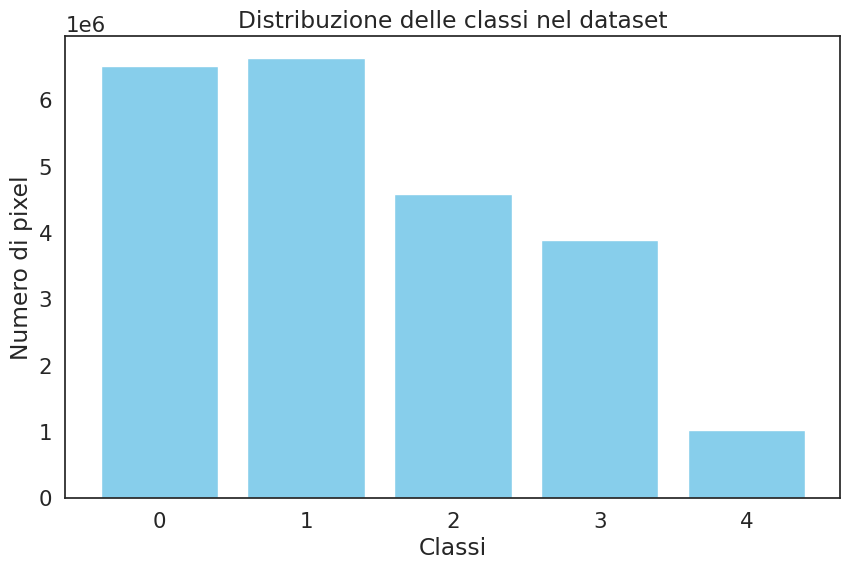

In [ ]:
import numpy as np



import matplotlib.pyplot as plt







def analyze_class_imbalance(y_train):



    """



    Analizza la distribuzione delle classi nel dataset di label (y_train).







    Args:



        y_train (numpy array): Dataset di label (es. (2615, 64, 128, 1)).







    Returns:



        class_counts (dict): Dizionario con le classi e la frequenza dei pixel.



    """



    # Appiattisci le label per contare i pixel



    y_flat = y_train.flatten()







    # Trova classi uniche e frequenza dei pixel



    unique_classes, pixel_counts = np.unique(y_flat, return_counts=True)







    # Calcola la distribuzione come proporzione



    total_pixels = np.sum(pixel_counts)



    class_distribution = pixel_counts / total_pixels







    # Stampa i risultati



    print("Distribuzione delle classi:")



    for cls, count, proportion in zip(unique_classes, pixel_counts, class_distribution):



        print(f"Classe {cls}: {count} pixel ({proportion:.2%})")







    # Grafico della distribuzione



    plt.figure(figsize=(10, 6))



    plt.bar(unique_classes, pixel_counts, color='skyblue')



    plt.xlabel("Classi")



    plt.ylabel("Numero di pixel")



    plt.title("Distribuzione delle classi nel dataset")



    plt.xticks(unique_classes)



    plt.show()







    # Restituisci i dati della distribuzione



    return dict(zip(unique_classes, pixel_counts))







# Esegui l'analisi sul dataset y_train



class_counts = analyze_class_imbalance(train_lbl)


In [ ]:
import numpy as np







def calculate_class_weights(y_train):



    """



    Calcola i pesi delle classi basandosi sulla distribuzione dei pixel in y_train.







    Args:



        y_train (numpy array): Dataset di label (es. (2615, 64, 128, 1)).







    Returns:



        class_weights (dict): Dizionario con i pesi delle classi {classe: peso}.



    """



    # Appiattisci le label per calcolare la frequenza



    y_flat = y_train.flatten()







    # Trova classi uniche e conta i pixel



    unique_classes, pixel_counts = np.unique(y_flat, return_counts=True)







    # Calcola i pesi come inverso della frequenza



    total_pixels = np.sum(pixel_counts)



    class_weights = {cls: total_pixels / (len(unique_classes) * count)



                     for cls, count in zip(unique_classes, pixel_counts)}







    print("Pesi calcolati per le classi:")



    for cls, weight in class_weights.items():



        print(f"Classe {cls}: Peso {weight:.4f}")







    return class_weights







# Calcola i pesi delle classi



class_weights = calculate_class_weights(train_lbl)


Pesi calcolati per le classi:
Classe 0.0: Peso 0.6961
Classe 1.0: Peso 0.6832
Classe 2.0: Peso 0.9884
Classe 3.0: Peso 1.1628
Classe 4.0: Peso 4.3889


In [ ]:
class_weights[0] = 0#results improved by loss that not consider the background

In [ ]:
# Definizione della category mapping



category_map = {



    0: 0,  # Background -> Background



    1: 1,  # Soil -> Soil



    2: 2,  # Bedrock -> Bedrock



    3: 3,  # Sand -> Sand



    4: 4,  # Big Rock -> Big Rock



}



NUM_CLASSES = 5  # Da 0 a 4



print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [ ]:
def load_single_image(image, label, input_size=(64, 128)):



    """



    Preprocessa un'immagine e la sua label.



    """



    # Resize e normalizza l'immagine



    image = tf.image.resize(image, input_size)



    image = tf.cast(image, tf.float32)







    # Resize la label



    label = tf.image.resize(label, input_size, method='nearest')  # Metodo adatto per label discrete



    label = tf.cast(label, tf.int32)  # Assicurati che le label siano interi







    return image, label


In [ ]:
def apply_category_mapping(label):



    """



    Apply category mapping to labels.



    """



    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)



    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)



    table = tf.lookup.StaticHashTable(



        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),



        default_value=0



    )



    return table.lookup(label)

In [ ]:


@tf.function



def random_flip(image, label, seed=None):



    #Consistent random horizontal flip.



    if seed is None:



        seed = np.random.randint(0, 1000000)



    flip_prob = tf.random.uniform([], seed=seed)



    image = tf.cond(



        flip_prob > 0.5,



        lambda: tf.image.flip_left_right(image),



        lambda: image



    )



    label = tf.cond(



        flip_prob > 0.5,



        lambda: tf.image.flip_left_right(label),



        lambda: label



    )



    return image, label


In [ ]:
@tf.function

def grid_mask(image, label, seed=None, d_min=10, d_max=50, r_min=0.3, r_max=0.7):

    """

    Applica Grid Mask su un'immagine.

    Parametri:

    - d_min, d_max: Range della dimensione del quadrato della griglia.

    - r_min, r_max: Proporzione di mascheratura nella griglia.

    """

    if seed is None:

        seed = tf.random.uniform([], maxval=1000000, dtype=tf.int32)



    # Estrai dimensioni immagine

    height, width, channels = tf.unstack(tf.shape(image))



    # Dimensione casuale della cella della griglia

    d = tf.random.uniform([], minval=d_min, maxval=d_max, dtype=tf.int32, seed=seed)



    # Proporzione di mascheratura casuale

    r = tf.random.uniform([], minval=r_min, maxval=r_max, dtype=tf.float32, seed=seed)



    # Creazione della maschera di base

    cut = tf.cast(tf.round(r * tf.cast(d, tf.float32)), tf.int32)

    mask_row = tf.concat([tf.ones((cut, d)), tf.zeros((d - cut, d))], axis=0)

    mask = tf.tile(mask_row, (height // d + 1, width // d + 1))

    mask = mask[:height, :width]  # Ritaglio alle dimensioni esatte



    # Inverti la maschera per applicare l'effetto di Grid Mask

    mask = 1 - mask



    # Aggiungi una dimensione per il canale

    mask = tf.expand_dims(mask, axis=-1)



    # Ridimensiona la maschera se necessario

    mask = tf.image.resize_with_crop_or_pad(mask, height, width)



    # Applica Grid Mask all'immagine

    image = image * mask



    return image, label


ALBUMENTATIONS FOR AUGMENTATIONS


In [ ]:
!pip install -U albumentations

In [ ]:
# 1. Definisci le trasformazioni di Albumentations
def get_augmentations():
    """
    Definisce trasformazioni aggressive di Albumentations.
    """
    return A.Compose([
        A.HorizontalFlip(p=0.7),              # Aumenta la probabilità di flip orizzontale
        A.VerticalFlip(p=0.7),                # Aumenta la probabilità di flip verticale
        A.Rotate(limit=45, p=0.9),            # Rotazione casuale entro ±45 gradi
        A.ElasticTransform(alpha=150, sigma=20, alpha_affine=30, p=0.5),  # Deformazioni elastiche più forti
        A.GridDistortion(num_steps=5, distort_limit=0.4, p=0.5),  # Distorsione della griglia più intensa
    ])

# 2. Funzione per applicare Albumentations
def albumentations_augment(image, mask):
    """
    Applica trasformazioni aggressive con Albumentations.
    - image: array numpy normalizzato (float32, range [0, 1]).
    - mask: array numpy con classi (interi).
    """
    # Converti il tensor TensorFlow in array NumPy
    image = image.numpy()
    mask = mask.numpy()

    # Applica le trasformazioni
    aug = get_augmentations()
    augmented = aug(image=image, mask=mask)
    image_aug, mask_aug = augmented['image'], augmented['mask']

    # Assicurati che i dati ritornino come float32
    return image_aug.astype(np.float32), mask_aug.astype(np.float32)

# 3. Wrapper per TensorFlow
def augment_with_albumentations(image, mask):
    """
    Wrapper per integrare Albumentations con tf.data.Dataset.
    """
    image, mask = tf.py_function(
        func=albumentations_augment,
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )
    # Mantieni la shape statica per TensorFlow
    image.set_shape([64, 128, 1])  # Specifica la dimensione dell'immagine
    mask.set_shape([64, 128, 1])   # Specifica la dimensione della maschera
    return image, mask


In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):



    """



    Create a memory-efficient TensorFlow dataset.



    """



    # Create dataset from file paths



    dataset = tf.data.Dataset.from_tensor_slices((images, labels))


    if shuffle:



        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)


    # Load images and labels

    dataset = dataset.map(



        load_single_image,



        num_parallel_calls=tf.data.AUTOTUNE



    )


    # Apply category mapping







    if augment:
      dataset = dataset.map(



            lambda x, y: random_flip(x, y, seed=seed),



            num_parallel_calls=tf.data.AUTOTUNE



        )


      #dataset = dataset.map(
          #  augment_with_albumentations,
         #   num_parallel_calls=tf.data.AUTOTUNE
        #)



    # Batch the data



    dataset = dataset.batch(batch_size, drop_remainder=False)



    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets



print("Creating datasets...")



train_dataset = make_dataset(



    train_img, train_lbl,



    batch_size=BATCH_SIZE,



    shuffle=True,



    augment=True,



    seed=seed



)







val_dataset = make_dataset(



    val_img, val_lbl,



    batch_size=BATCH_SIZE,



    shuffle=False



)



"""



test_dataset = make_dataset(



    test_img, test_lbl,



    batch_size=BATCH_SIZE,



    shuffle=False



)



"""



print("Datasets created!")







# Check the shape of the data



for images, labels in train_dataset.take(1):



    input_shape = images.shape[1:]



    print(f"\nInput shape: {input_shape}")



    print("Images shape:", images.shape)



    print("Labels shape:", labels.shape)



    print("Labels dtype:", labels.dtype)



    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


(2765, 64, 128, 1)
Visualizing examples from the training set:


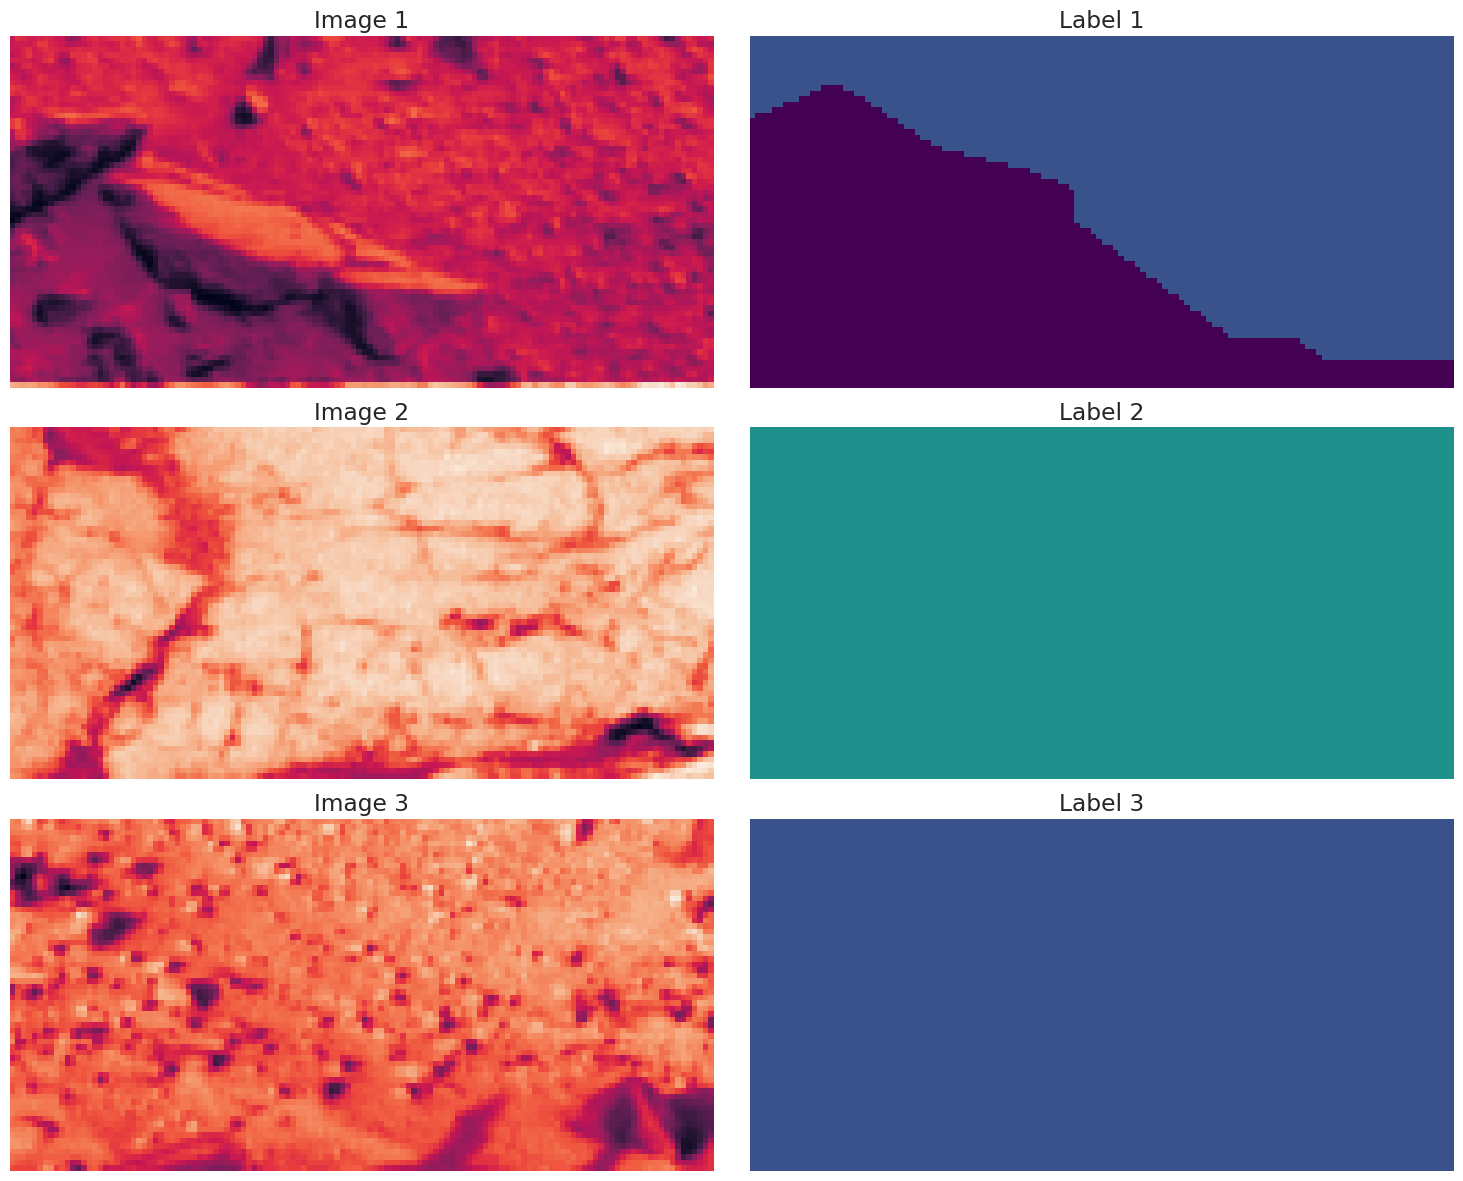

In [ ]:


def create_segmentation_colormap(num_classes):

    """

    Create a linear colormap using a predefined palette.

    Uses 'viridis' as default because it is perceptually uniform

    and works well for colorblindness.

    """

    return plt.cm.viridis(np.linspace(0, 1, num_classes))



COLORMAP = create_segmentation_colormap(NUM_CLASSES)



def apply_colormap(label, colormap=None):

    """

    Apply the colormap to a label.

    """

    # Ensure label is 2D

    label = np.squeeze(label)



    colormap = COLORMAP



    # Validate colormap size

    max_label = label.max()

    if max_label >= colormap.shape[0]:

        raise ValueError(f"Label contains value {max_label}, but colormap has only {colormap.shape[0]} colors.")





    # Apply the colormap

    colored = colormap[label.astype(int)]



    return colored



def plot_sample_batch(dataset, num_samples=3):

    """

    Display some image and label pairs from the dataset.

    """

    plt.figure(figsize=(15, 4*num_samples))



    for images, labels in dataset.take(1):

        labels_np = labels.numpy()

        num_classes = len(np.unique(labels_np))

        colormap = COLORMAP



        for j in range(min(num_samples, len(images))):

            # Plot original image

            plt.subplot(num_samples, 2, j*2 + 1)

            plt.imshow(images[j])

            plt.title(f'Image {j+1}')

            plt.axis('off')



            # Plot colored label

            plt.subplot(num_samples, 2, j*2 + 2)

            colored_label = apply_colormap(labels_np[j], colormap)

            plt.imshow(colored_label)

            plt.title(f'Label {j+1}')

            plt.axis('off')



    plt.tight_layout()

    plt.show()

    plt.close()



print(train_img.shape)

# Visualize examples from the training set

print("Visualizing examples from the training set:")

plot_sample_batch(train_dataset, num_samples=3)

## 🛠️ Models and Experiments

In [ ]:


import keras_cv
"""
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):



    # Initialise the input tensor



    x = input_tensor







    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks



    for i in range(stack):



        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)



        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)



        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)







    # Return the transformed tensor



    return x
"""
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    """
    Blocco UNet con residual connections.
    - input_tensor: Tensor di input.
    - filters: Numero di filtri per le convoluzioni.
    - kernel_size: Dimensione del kernel convoluzionale.
    - activation: Funzione di attivazione.
    - stack: Numero di convoluzioni nello stack.
    - name: Nome del blocco.
    """
    x = input_tensor
    shortcut = input_tensor  # Connessione residua

    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=f"{name}conv{i + 1}")(x)
        x = tfkl.BatchNormalization(name=f"{name}bn{i + 1}")(x)
        x = tfkl.Activation(activation, name=f"{name}activation{i + 1}")(x)

    # Aggiungi la connessione residua
    if shortcut.shape[-1] != filters:  # Adatta i canali se necessario
        shortcut = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f"{name}shortcut")(shortcut)

    x = tfkl.Add(name=f"{name}add")([x, shortcut])
    x = tfkl.Activation(activation, name=f"{name}residual_activation")(x)

    return x



def squeeze_and_excite_block(input_tensor, ratio=16):
    """
    Squeeze-and-Excitation block to recalibrate channel-wise feature responses.

    Args:
        input_tensor: Input feature map.
        ratio: Reduction ratio for the dense layers in the SE block.

    Returns:
        Output tensor with recalibrated features.
    """
    channel_axis = -1  # Assuming 'channels_last' format
    filters = input_tensor.shape[channel_axis]

    # Squeeze: Global Average Pooling
    squeeze = tfkl.GlobalAveragePooling2D()(input_tensor)

    # Excitation: Fully connected layers with reduction ratio
    excitation = tfkl.Dense(filters // ratio, activation="relu")(squeeze)
    excitation = tfkl.Dense(filters, activation="sigmoid")(excitation)

    # Reshape and scale
    excitation = tfkl.Reshape((1, 1, filters))(excitation)
    output_tensor = tfkl.multiply([input_tensor, excitation])
    return output_tensor




def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):

    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')



    # Aggiungi Grid Mask

    input_layer = keras_cv.layers.GridMask(

        ratio_factor=(0.2, 0.4),    # Proporzione di maschera oscurata

        rotation_factor=0.1,       # Rotazione casuale

        fill_mode="constant"       # Riempimento delle aree oscurate

    )(input_layer)



    # Downsampling path

    down_block_1 = unet_block(input_layer, 32, name='down_block1_')

    d1 = tfkl.MaxPooling2D()(down_block_1)



    down_block_2 = unet_block(d1, 64, name='down_block2_')

    d2 = tfkl.MaxPooling2D()(down_block_2)



    # Bottleneck

    bottleneck = unet_block(d2, 128, name='bottleneck')
    # Add squeeze and excitation block to the bottleneck to make it more informative
    bottleneck = squeeze_and_excite_block(bottleneck, ratio=16)


    # Upsampling path

    u1 = tfkl.UpSampling2D()(bottleneck)

    u1 = tfkl.Concatenate()([u1, down_block_2])

    u1 = unet_block(u1, 64, name='up_block1_')



    u2 = tfkl.UpSampling2D()(u1)

    u2 = tfkl.Concatenate()([u2, down_block_1])

    u2 = unet_block(u2, 32, name='up_block2_')



    # Output Layer

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)



    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')

    return model





model = get_unet_model(input_shape=IMAGE_SIZE)







# Print a detailed summary of the model with expanded nested layers and trainable parameters.



model.summary(expand_nested=True, show_trainable=True)







# Generate and display a graphical representation of the model architecture.



#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ keras_tensor_58CLONE   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ keras_tensor_58CLO… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[1]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[1]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_shortcut   │ (None, 64, 128, 32)  │           64 │ keras_tensor_58CLO… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_add (Add)  │ (None, 64, 128, 32)  │            0 │ down_block1_activa… │    -    │
│                        │                      │              │ down_block1_shortc… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_residual_… │ (None, 64, 128, 32)  │            0 │ down_block1_add[1]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 32)   │            0 │ down_block1_residu… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_2[1]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 501,805 (1.91 MB)

 Trainable params: 500,525 (1.91 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Define custom Mean Intersection Over Union metric



class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):



    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):



        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)



        if labels_to_exclude is None:



            labels_to_exclude = [0]  # Default to excluding label 0



        self.labels_to_exclude = labels_to_exclude







    def update_state(self, y_true, y_pred, sample_weight=None):



        # Convert predictions to class labels



        y_pred = tf.math.argmax(y_pred, axis=-1)







        # Flatten the tensors



        y_true = tf.reshape(y_true, [-1])



        y_pred = tf.reshape(y_pred, [-1])







        # Apply mask to exclude specified labels



        for label in self.labels_to_exclude:



            mask = tf.not_equal(y_true, label)



            y_true = tf.boolean_mask(y_true, mask)



            y_pred = tf.boolean_mask(y_pred, mask)







        # Update the state



        return super().update_state(y_true, y_pred, sample_weight)







# Visualization callback



class VizCallback(tf.keras.callbacks.Callback):



    def __init__(self, image_path, label_path, frequency=5):



        super().__init__()



        self.image_path = image_path



        self.label_path = label_path



        self.frequency = frequency







    def on_epoch_end(self, epoch, logs=None):



        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs



            image, label = load_single_image(self.image_path, self.label_path)



            label = apply_category_mapping(label)



            image = tf.expand_dims(image, 0)



            pred = self.model.predict(image, verbose=0)



            y_pred = tf.math.argmax(pred, axis=-1)



            y_pred = y_pred.numpy()







            # Create colormap



            num_classes = NUM_CLASSES



            colormap = create_segmentation_colormap(num_classes)







            plt.figure(figsize=(16, 4))







            # Input image



            plt.subplot(1, 3, 1)



            plt.imshow(image[0])



            plt.title("Input Image")



            plt.axis('off')







            # Ground truth



            plt.subplot(1, 3, 2)



            colored_label = apply_colormap(label.numpy(), colormap)



            plt.imshow(colored_label)



            plt.title("Ground Truth Mask")



            plt.axis('off')







            # Prediction



            plt.subplot(1, 3, 3)



            colored_pred = apply_colormap(y_pred[0], colormap)



            plt.imshow(colored_pred)



            plt.title("Predicted Mask")



            plt.axis('off')







            plt.tight_layout()



            plt.show()



#            plt.close()

In [ ]:
# Define custom Mean Intersection Over Union metric



class IoUPerClass(tf.keras.metrics.Metric):

    def __init__(self, num_classes, labels_to_exclude=[0], name='iou_per_class', **kwargs):

        super(IoUPerClass, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes

        self.labels_to_exclude = labels_to_exclude



        # Usa tf.Variable per creare variabili mutabili

        self.true_positives = tf.Variable(tf.zeros((num_classes,), dtype=tf.float32), trainable=False)

        self.false_positives = tf.Variable(tf.zeros((num_classes,), dtype=tf.float32), trainable=False)

        self.false_negatives = tf.Variable(tf.zeros((num_classes,), dtype=tf.float32), trainable=False)



    def update_state(self, y_true, y_pred, sample_weight=None):



        y_pred = tf.math.argmax(y_pred, axis=-1)



        # Assicurati che y_true e y_pred siano in formato int32

        y_true = tf.cast(y_true, dtype=tf.int32)

        y_pred = tf.cast(y_pred, dtype=tf.int32)



        # Appiattisci y_true e y_pred per confrontarli elemento per elemento

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])



        # Crea una maschera per escludere le etichette specificate

        mask = tf.reduce_all(tf.not_equal(tf.expand_dims(y_true, -1), self.labels_to_exclude), axis=-1)



        # Applica la maschera per escludere i valori indesiderati

        y_true = tf.boolean_mask(y_true, mask)

        y_pred = tf.boolean_mask(y_pred, mask)



        # Calcola i veri positivi (TP), falsi positivi (FP) e falsi negativi (FN) per ogni classe

        true_positives_per_class = []

        false_positives_per_class = []

        false_negatives_per_class = []



        for class_id in range(self.num_classes):

            true_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))

            false_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))

            false_negative = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.not_equal(y_pred, class_id)), tf.float32))



            true_positives_per_class.append(true_positive)

            false_positives_per_class.append(false_positive)

            false_negatives_per_class.append(false_negative)



        # Converte le liste in tensori

        true_positives_per_class = tf.convert_to_tensor(true_positives_per_class, dtype=tf.float32)

        false_positives_per_class = tf.convert_to_tensor(false_positives_per_class, dtype=tf.float32)

        false_negatives_per_class = tf.convert_to_tensor(false_negatives_per_class, dtype=tf.float32)



        # Aggiorna i contatori per TP, FP e FN

        self.true_positives.assign_add(true_positives_per_class)

        self.false_positives.assign_add(false_positives_per_class)

        self.false_negatives.assign_add(false_negatives_per_class)



    def result(self):

        # Calcola l'IoU per ciascuna classe

        iou_per_class = tf.where(

            tf.math.greater(self.true_positives + self.false_positives + self.false_negatives, 0),

            self.true_positives / (self.true_positives + self.false_positives + self.false_negatives),

            tf.zeros_like(self.true_positives),

        )

        return iou_per_class



    def reset_state(self):

        # Reset dei contatori per TP, FP, FN

        self.true_positives.assign(tf.zeros_like(self.true_positives))

        self.false_positives.assign(tf.zeros_like(self.false_positives))

        self.false_negatives.assign(tf.zeros_like(self.false_negatives))


In [ ]:
def dice_loss(y_true, y_pred):

    smooth = 1e-6



    # Numero di classi dal modello (y_pred)

    num_classes = tf.shape(y_pred)[-1]



    # Converti y_true in one-hot

    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)



    # Rimuovi la dimensione extra (se presente)

    y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)



    # Applica softmax a y_pred

    y_pred = tf.nn.softmax(y_pred, axis=-1)



    # Calcola intersezione e unione

    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[0, 1, 2])

    union = tf.reduce_sum(y_true_one_hot, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2])



    dice = (2. * intersection + smooth) / (union + smooth)



    # Restituisci 1 - Dice score per ottenere la loss

    return 1 - tf.reduce_mean(dice)



def combined_loss(y_true, y_pred):

    alpha = 0.8#0.8

    beta = 0.2#0.2

    return alpha * dice_loss(y_true, y_pred) + beta * tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)


In [ ]:
list(class_weights.values())

[0,
 0.6831743117135413,
 0.98840879348557,
 1.1627696147506354,
 4.3888931409012475]

In [ ]:
import tensorflow as tf

def focal_loss(y_true, y_pred, gamma=2.0, alpha=list(class_weights.values())):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1 - 1e-6)  # Evita log(0)
    y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])

    # Pesi delle classi
    alpha_tensor = tf.constant(alpha, dtype=tf.float32)

    # Calcola la Focal Loss
    weight = tf.gather(alpha_tensor, y_true)
    focal_loss = -weight * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

def combined_loss_FocalCross(y_true, y_pred, alpha=0.5, beta=0.5, gamma=2.0, focal_alpha=0.25):
    """
    Combina Focal Loss e Sparse Categorical Crossentropy.

    Args:
        y_true: Ground truth (valori reali).
        y_pred: Predizioni del modello.
        alpha: Peso della Focal Loss.
        beta: Peso della Sparse Categorical Crossentropy.
        gamma: Fattore gamma per la Focal Loss.
        focal_alpha: Peso alpha per la Focal Loss.

    Returns:
        Combined loss scalare.
    """
    focal = focal_loss(y_true, y_pred, gamma=gamma, alpha=focal_alpha)
    sparse_ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return alpha * focal + beta * sparse_ce


In [ ]:
import tensorflow as tf



def weighted_sparse_categorical_crossentropy(class_weights):

    """

    Crea una funzione di perdita ponderata per la segmentazione semantica.



    Args:

        class_weights (dict): Dizionario con i pesi delle classi {classe: peso}.



    Returns:

        loss_fn: Funzione di perdita personalizzata.

    """

    def loss_fn(y_true, y_pred):

        # Assicurati che y_true sia int (necessario per tf.gather)

        y_true = tf.cast(y_true, tf.int32)



        # Calcola i pesi per ciascun pixel in y_true

        weights = tf.gather(tf.constant(list(class_weights.values()), dtype=tf.float32), y_true)



        # Rimuovi dimensioni extra da weights

        weights = tf.squeeze(weights, axis=-1)  # Rimuove l'ultimo asse, se presente



        # Calcola la SparseCategoricalCrossentropy

        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)



        # Moltiplica la perdita per i pesi dei pixel

        weighted_loss = scce * weights



        # Restituisci la perdita media ponderata

        return tf.reduce_mean(weighted_loss)



    return loss_fn


In [ ]:
# Compile the model







print("Compiling model...")



model.compile(



    loss= weighted_sparse_categorical_crossentropy(class_weights),#tf.keras.losses.SparseCategoricalCrossentropy()



    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,weight_decay=1e-4),



    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]), IoUPerClass(num_classes=NUM_CLASSES)]



)



print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks



early_stopping = tf.keras.callbacks.EarlyStopping(



    monitor='val_mean_iou',



    mode='max',



    patience=PATIENCE,



    restore_best_weights=True



)







viz_callback = VizCallback(val_img[0], val_lbl[0])













reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(

    monitor='val_mean_iou',  # Puoi cambiare con 'val_mean_io_u' se usi IoU

    mode="max",

    factor=0.1,          # Riduci il learning rate di 0.2, prima era di 0.5

    patience=10,          # Aspetta 5 epoche senza miglioramenti

    min_delta=0.001,

    min_lr=1e-5,         # Non scendere sotto 1e-6

    verbose=1            # Mostra messaggi quando il learning rate cambia



)


In [ ]:
class IoUCallback(tf.keras.callbacks.Callback):

    def __init__(self, frequency=5, **kwargs):

        super(IoUCallback, self).__init__(**kwargs)  # Non passiamo 'name' al costruttore di Callback

        self.frequency = frequency  # Numero di epoche tra i calcoli



    def on_epoch_end(self, epoch, logs=None):

        # Verifica che l'epoca sia un multiplo di "frequency"

        if (epoch + 1) % self.frequency == 0:

            logs = logs or {}  # Assicura che logs sia un dizionario



            # Ottieni l'IoU per classe utilizzando il metodo result()

            iou_per_class = logs.get('iou_per_class')



            # Verifica se iou_per_class è disponibile e non None

            if iou_per_class is not None and tf.is_tensor(iou_per_class) and iou_per_class.shape.ndims > 0:

                for i, iou in enumerate(iou_per_class.numpy()):  # Converte in numpy per la stampa

                    print(f"Epoch {epoch + 1}, IoU for class {i}: {iou:.4f}")

            else:

                print(f"Epoch {epoch + 1}, IoU per class not available or empty.")


Epoch 1/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.3695 - iou_per_class: 0.2112 - loss: 0.8026 - mean_iou: 0.2112

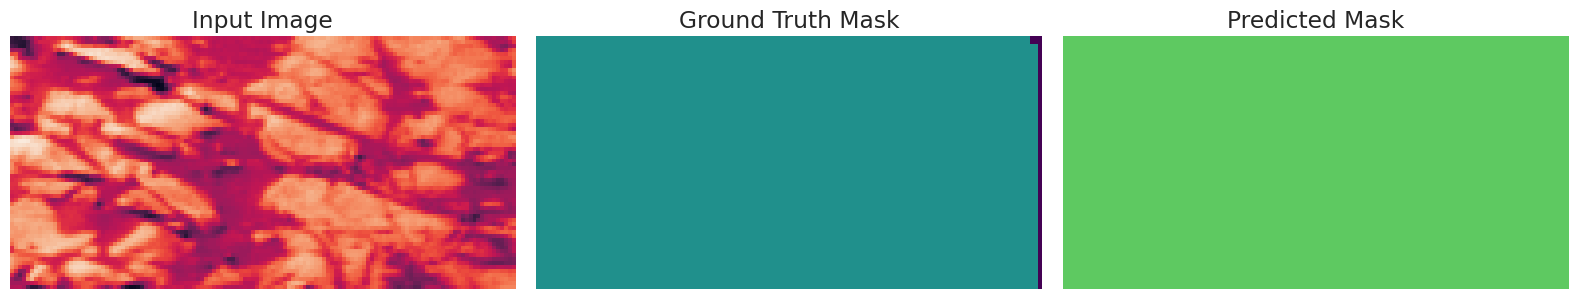

44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3696 - iou_per_class: 0.2125 - loss: 0.8094 - mean_iou: 0.2125 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 1.1756 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step - accuracy: 0.2237 - iou_per_class: 0.1495 - loss: 1.1516 - mean_iou: 0.1869 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 1.7419 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.2926 - iou_per_class: 0.1801 - loss: 0.9152 - mean_iou: 0.2251 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 2.9303 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.3054 - iou_per_class: 0.2033 - loss: 0.8743 - mean_iou: 0.2541 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 3.2020 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 5/1000
43/44 

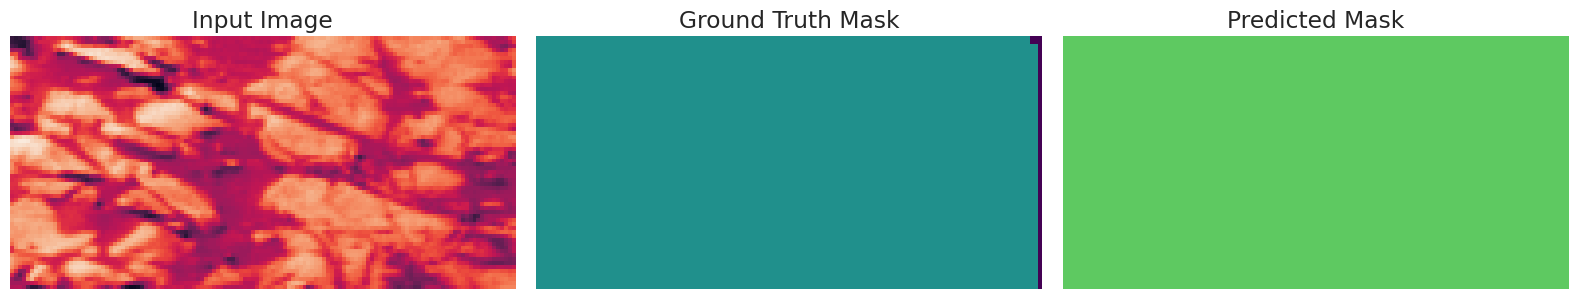

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.3661 - iou_per_class: 0.2457 - loss: 0.7670 - mean_iou: 0.3072 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 2.1166 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 7/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.4217 - iou_per_class: 0.2808 - loss: 0.7261 - mean_iou: 0.3510 - val_accuracy: 0.2132 - val_iou_per_class: 0.0566 - val_loss: 1.8291 - val_mean_iou: 0.0707 - learning_rate: 0.0010
Epoch 8/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.3831 - iou_per_class: 0.2541 - loss: 0.7828 - mean_iou: 0.3176 - val_accuracy: 0.2187 - val_iou_per_class: 0.0624 - val_loss: 1.5440 - val_mean_iou: 0.0780 - learning_rate: 0.0010
Epoch 9/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.4140 - iou_per_class: 0.2849 - loss: 0.7106 - mean_iou: 0.3561 - val_accuracy: 0.2137 - val_iou_per_class: 0.0572 - val_loss: 1.5174 - val_mean_iou: 0.0715 - learning_rate: 0.0010
Epoch 10/1000
43/44 

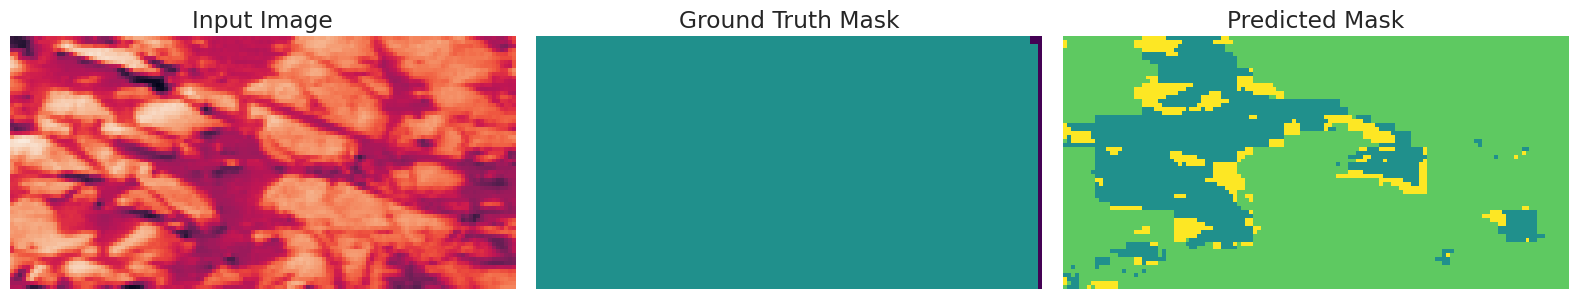

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.4329 - iou_per_class: 0.2964 - loss: 0.7010 - mean_iou: 0.3705 - val_accuracy: 0.2689 - val_iou_per_class: 0.1194 - val_loss: 1.2022 - val_mean_iou: 0.1493 - learning_rate: 0.0010
Epoch 12/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.4468 - iou_per_class: 0.3081 - loss: 0.6649 - mean_iou: 0.3851 - val_accuracy: 0.3020 - val_iou_per_class: 0.1473 - val_loss: 1.0625 - val_mean_iou: 0.1841 - learning_rate: 0.0010
Epoch 13/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.4197 - iou_per_class: 0.2873 - loss: 0.7026 - mean_iou: 0.3591 - val_accuracy: 0.2854 - val_iou_per_class: 0.1379 - val_loss: 1.1160 - val_mean_iou: 0.1723 - learning_rate: 0.0010
Epoch 14/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.4594 - iou_per_class: 0.3230 - loss: 0.6495 - mean_iou: 0.4037 - val_accuracy: 0.3133 - val_iou_per_class: 0.1618 - val_loss: 1.0561 - val_mean_iou: 0.2022 - learning_rate: 0.0010
Epoch 15/1000
4

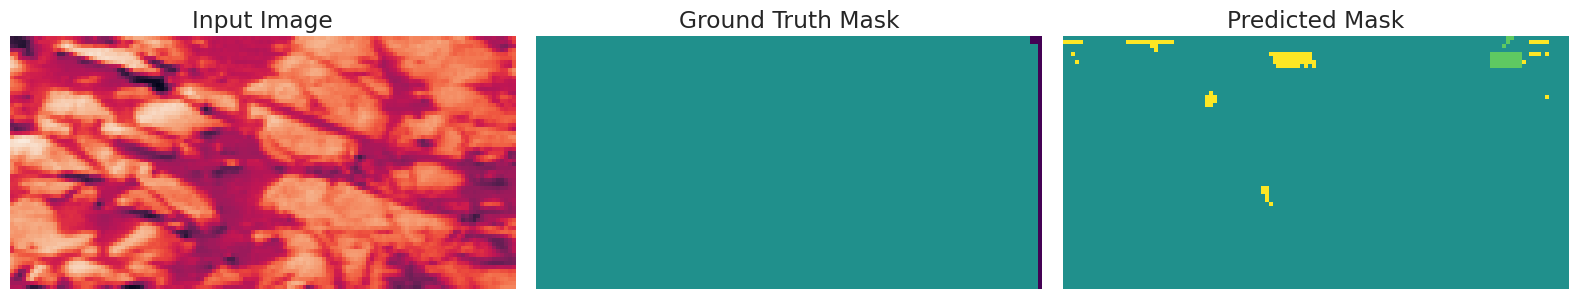

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4658 - iou_per_class: 0.3231 - loss: 0.6434 - mean_iou: 0.4038 - val_accuracy: 0.3814 - val_iou_per_class: 0.2108 - val_loss: 0.8956 - val_mean_iou: 0.2635 - learning_rate: 0.0010
Epoch 17/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.4787 - iou_per_class: 0.3360 - loss: 0.6343 - mean_iou: 0.4201 - val_accuracy: 0.2913 - val_iou_per_class: 0.1559 - val_loss: 1.2287 - val_mean_iou: 0.1948 - learning_rate: 0.0010
Epoch 18/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.4791 - iou_per_class: 0.3361 - loss: 0.6236 - mean_iou: 0.4202 - val_accuracy: 0.3121 - val_iou_per_class: 0.1890 - val_loss: 1.0045 - val_mean_iou: 0.2362 - learning_rate: 0.0010
Epoch 19/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.4478 - iou_per_class: 0.3133 - loss: 0.6576 - mean_iou: 0.3916 - val_accuracy: 0.2859 - val_iou_per_class: 0.1708 - val_loss: 0.9139 - val_mean_iou: 0.2135 - learning_rate: 0.0010
Epoch 20/1000
43

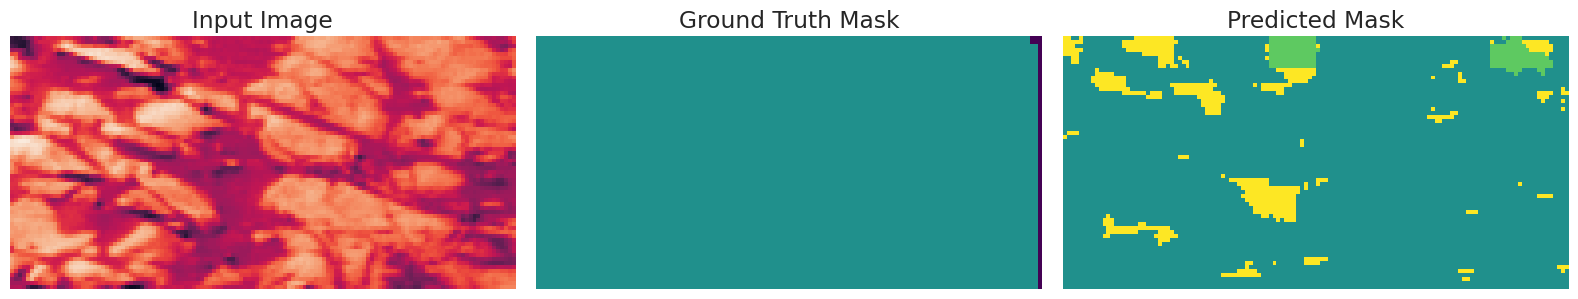

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.5047 - iou_per_class: 0.3543 - loss: 0.5711 - mean_iou: 0.4429 - val_accuracy: 0.3071 - val_iou_per_class: 0.1677 - val_loss: 1.1544 - val_mean_iou: 0.2096 - learning_rate: 0.0010
Epoch 22/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.5100 - iou_per_class: 0.3614 - loss: 0.5575 - mean_iou: 0.4518 - val_accuracy: 0.1607 - val_iou_per_class: 0.1297 - val_loss: 1.5989 - val_mean_iou: 0.1621 - learning_rate: 0.0010
Epoch 23/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.5046 - iou_per_class: 0.3561 - loss: 0.5458 - mean_iou: 0.4451 - val_accuracy: 0.2724 - val_iou_per_class: 0.1911 - val_loss: 1.1049 - val_mean_iou: 0.2389 - learning_rate: 0.0010
Epoch 24/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5161 - iou_per_class: 0.3716 - loss: 0.5401 - mean_iou: 0.4646 - val_accuracy: 0.1674 - val_iou_per_class: 0.0968 - val_loss: 1.6051 - val_mean_iou: 0.1210 - learning_rate: 0.0010
Epoch 25/1000
43

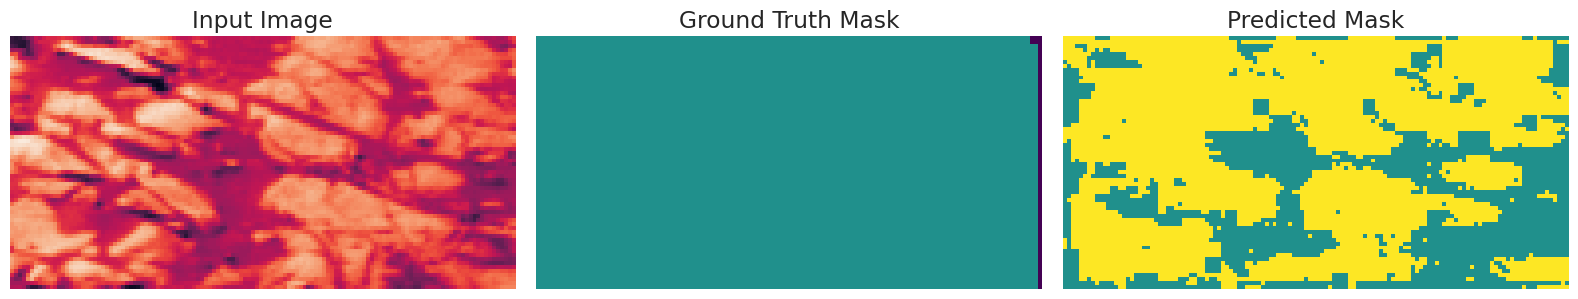

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.4947 - iou_per_class: 0.3507 - loss: 0.5527 - mean_iou: 0.4384 - val_accuracy: 0.4031 - val_iou_per_class: 0.2667 - val_loss: 0.8793 - val_mean_iou: 0.3334 - learning_rate: 0.0010
Epoch 27/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.5292 - iou_per_class: 0.3824 - loss: 0.5129 - mean_iou: 0.4780 - val_accuracy: 0.1734 - val_iou_per_class: 0.1077 - val_loss: 1.4022 - val_mean_iou: 0.1346 - learning_rate: 0.0010
Epoch 28/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.5222 - iou_per_class: 0.3778 - loss: 0.5337 - mean_iou: 0.4723 - val_accuracy: 0.0984 - val_iou_per_class: 0.0654 - val_loss: 1.8980 - val_mean_iou: 0.0817 - learning_rate: 0.0010
Epoch 29/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.5268 - iou_per_class: 0.3756 - loss: 0.4946 - mean_iou: 0.4695 - val_accuracy: 0.2952 - val_iou_per_class: 0.1996 - val_loss: 0.9961 - val_mean_iou: 0.2496 - learning_rate: 0.0010
Epoch 30/1000
43/4

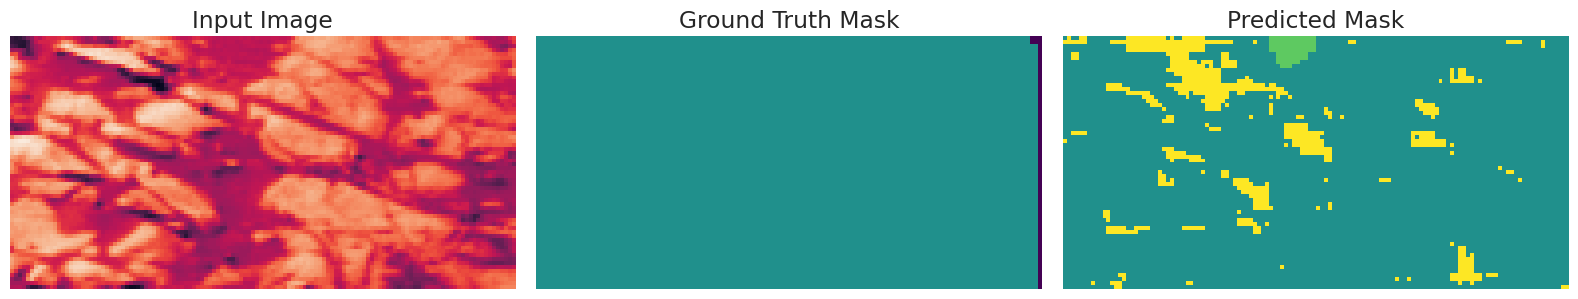

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.5679 - iou_per_class: 0.4125 - loss: 0.4332 - mean_iou: 0.5156 - val_accuracy: 0.3751 - val_iou_per_class: 0.2311 - val_loss: 1.0258 - val_mean_iou: 0.2889 - learning_rate: 0.0010
Epoch 32/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5658 - iou_per_class: 0.4130 - loss: 0.4287 - mean_iou: 0.5162 - val_accuracy: 0.3238 - val_iou_per_class: 0.1865 - val_loss: 1.0630 - val_mean_iou: 0.2331 - learning_rate: 0.0010
Epoch 33/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.5956 - iou_per_class: 0.4350 - loss: 0.3900 - mean_iou: 0.5438 - val_accuracy: 0.3181 - val_iou_per_class: 0.1958 - val_loss: 1.0792 - val_mean_iou: 0.2447 - learning_rate: 0.0010
Epoch 34/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.5966 - iou_per_class: 0.4390 - loss: 0.3709 - mean_iou: 0.5487 - val_accuracy: 0.4480 - val_iou_per_class: 0.2597 - val_loss: 0.8382 - val_mean_iou: 0.3246 - learning_rate: 0.0010
Epoch 35/1000
43/

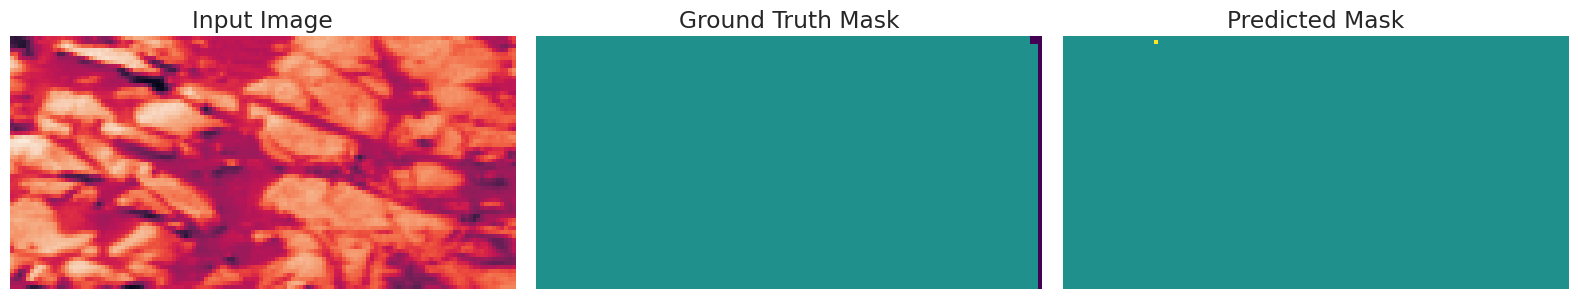

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6353 - iou_per_class: 0.4821 - loss: 0.3045 - mean_iou: 0.6027 - val_accuracy: 0.5966 - val_iou_per_class: 0.3993 - val_loss: 0.3788 - val_mean_iou: 0.4991 - learning_rate: 0.0010
Epoch 37/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6327 - iou_per_class: 0.4833 - loss: 0.2933 - mean_iou: 0.6041 - val_accuracy: 0.4605 - val_iou_per_class: 0.2847 - val_loss: 0.6374 - val_mean_iou: 0.3559 - learning_rate: 0.0010
Epoch 38/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6354 - iou_per_class: 0.4897 - loss: 0.2974 - mean_iou: 0.6122 - val_accuracy: 0.4665 - val_iou_per_class: 0.2882 - val_loss: 0.6773 - val_mean_iou: 0.3603 - learning_rate: 0.0010
Epoch 39/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6427 - iou_per_class: 0.4989 - loss: 0.2652 - mean_iou: 0.6236 - val_accuracy: 0.3818 - val_iou_per_class: 0.2227 - val_loss: 0.7999 - val_mean_iou: 0.2783 - learning_rate: 0.0010
Epoch 40/1000
43

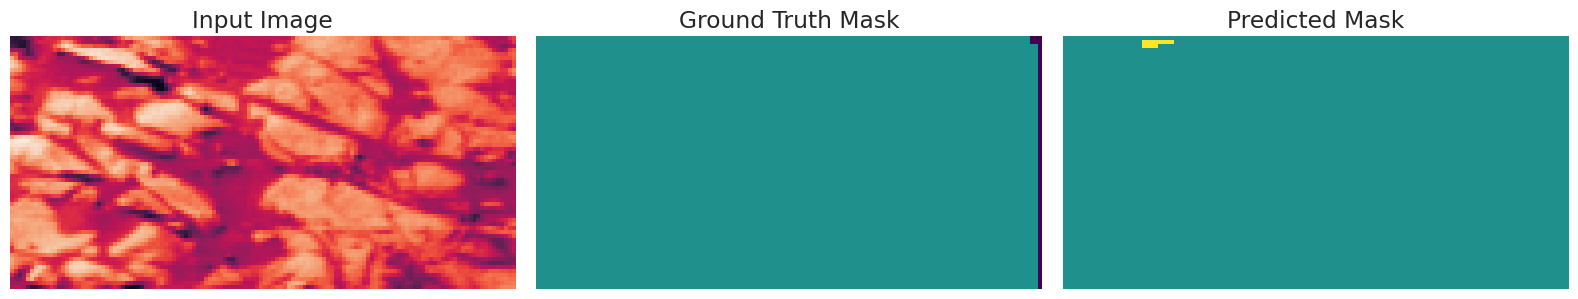

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6358 - iou_per_class: 0.4977 - loss: 0.2903 - mean_iou: 0.6221 - val_accuracy: 0.3947 - val_iou_per_class: 0.2505 - val_loss: 0.9036 - val_mean_iou: 0.3131 - learning_rate: 0.0010
Epoch 42/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6124 - iou_per_class: 0.4621 - loss: 0.3130 - mean_iou: 0.5777 - val_accuracy: 0.2855 - val_iou_per_class: 0.1816 - val_loss: 1.5203 - val_mean_iou: 0.2270 - learning_rate: 0.0010
Epoch 43/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.6231 - iou_per_class: 0.4692 - loss: 0.3058 - mean_iou: 0.5865 - val_accuracy: 0.4682 - val_iou_per_class: 0.2977 - val_loss: 0.8159 - val_mean_iou: 0.3722 - learning_rate: 0.0010
Epoch 44/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6175 - iou_per_class: 0.4591 - loss: 0.3235 - mean_iou: 0.5739 - val_accuracy: 0.4972 - val_iou_per_class: 0.2794 - val_loss: 0.6511 - val_mean_iou: 0.3492 - learning_rate: 0.0010
Epoch 45/1000
43/

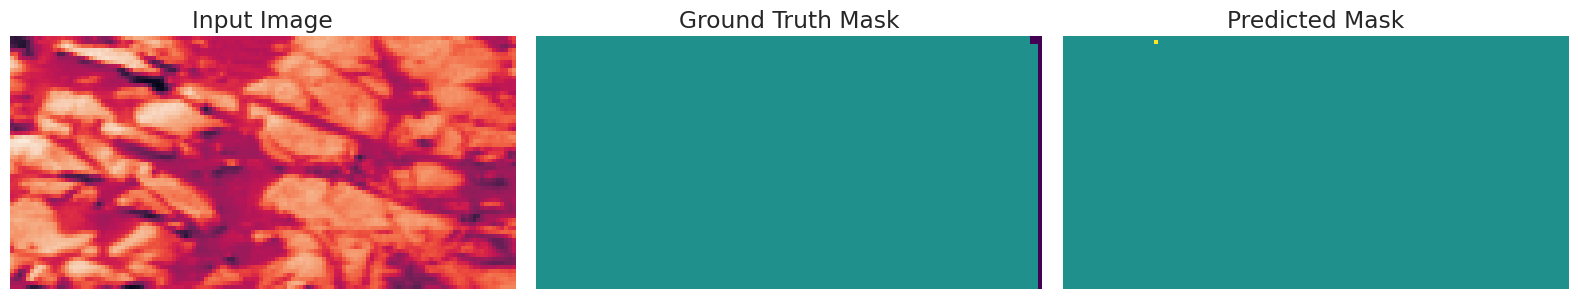


Epoch 46: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.6464 - iou_per_class: 0.5163 - loss: 0.2538 - mean_iou: 0.6454 - val_accuracy: 0.5266 - val_iou_per_class: 0.3354 - val_loss: 0.5695 - val_mean_iou: 0.4193 - learning_rate: 0.0010
Epoch 47/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.6481 - iou_per_class: 0.5334 - loss: 0.2459 - mean_iou: 0.6668 - val_accuracy: 0.6172 - val_iou_per_class: 0.4207 - val_loss: 0.3495 - val_mean_iou: 0.5259 - learning_rate: 1.0000e-04
Epoch 48/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.6640 - iou_per_class: 0.5599 - loss: 0.2115 - mean_iou: 0.6999 - val_accuracy: 0.6074 - val_iou_per_class: 0.4015 - val_loss: 0.3438 - val_mean_iou: 0.5019 - learning_rate: 1.0000e-04
Epoch 49/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6660 - iou_per_class: 0.5706 - loss: 0.2066 - mean_iou: 0.7132 - val_accuracy: 0.6217 - val_iou_per_class: 0

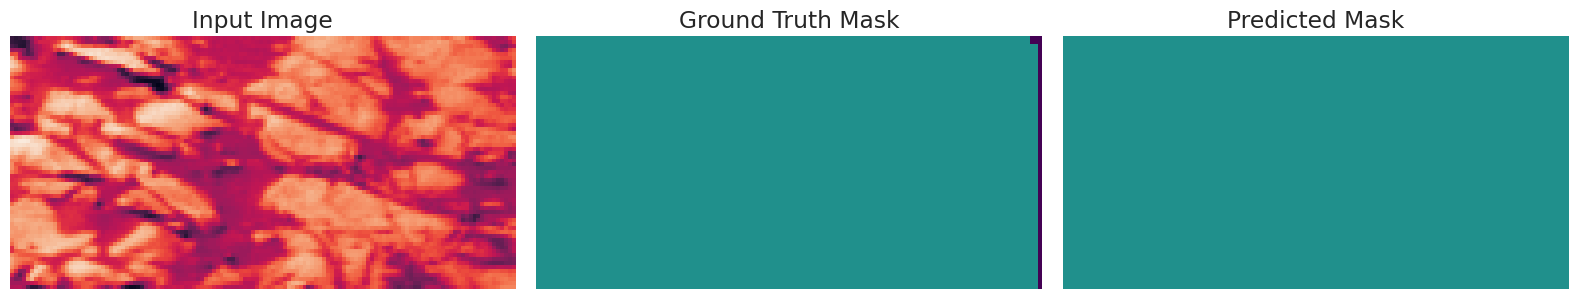

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.6706 - iou_per_class: 0.5697 - loss: 0.2038 - mean_iou: 0.7121 - val_accuracy: 0.6263 - val_iou_per_class: 0.4231 - val_loss: 0.3121 - val_mean_iou: 0.5288 - learning_rate: 1.0000e-04
Epoch 52/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6716 - iou_per_class: 0.5661 - loss: 0.2004 - mean_iou: 0.7076 - val_accuracy: 0.6273 - val_iou_per_class: 0.4240 - val_loss: 0.3056 - val_mean_iou: 0.5300 - learning_rate: 1.0000e-04
Epoch 53/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6701 - iou_per_class: 0.5685 - loss: 0.1982 - mean_iou: 0.7106 - val_accuracy: 0.6278 - val_iou_per_class: 0.4245 - val_loss: 0.3036 - val_mean_iou: 0.5307 - learning_rate: 1.0000e-04
Epoch 54/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6704 - iou_per_class: 0.5645 - loss: 0.2001 - mean_iou: 0.7057 - val_accuracy: 0.6250 - val_iou_per_class: 0.4215 - val_loss: 0.3126 - val_mean_iou: 0.5269 - learning_rate: 1.0000e-04
E

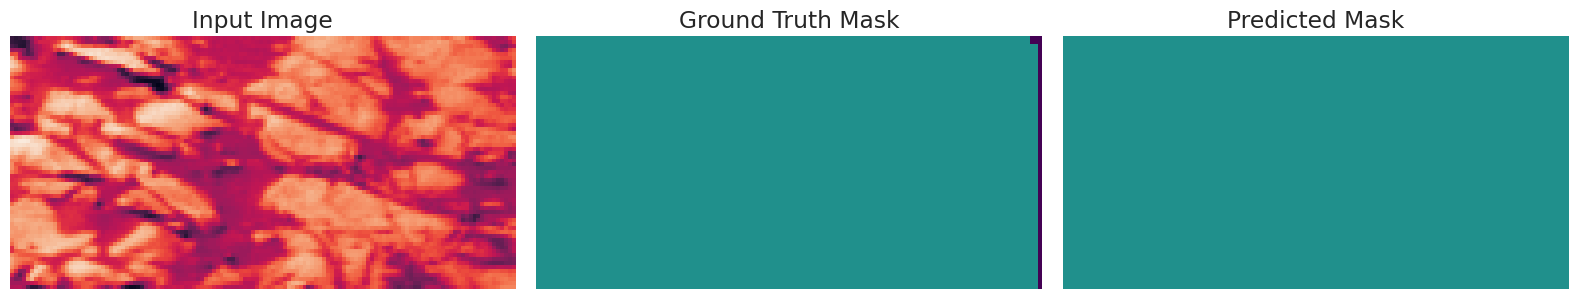

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.6703 - iou_per_class: 0.5646 - loss: 0.2012 - mean_iou: 0.7058 - val_accuracy: 0.6424 - val_iou_per_class: 0.4425 - val_loss: 0.2770 - val_mean_iou: 0.5531 - learning_rate: 1.0000e-04
Epoch 57/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6680 - iou_per_class: 0.5695 - loss: 0.2029 - mean_iou: 0.7119 - val_accuracy: 0.6341 - val_iou_per_class: 0.4331 - val_loss: 0.2887 - val_mean_iou: 0.5414 - learning_rate: 1.0000e-04
Epoch 58/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6705 - iou_per_class: 0.5614 - loss: 0.1995 - mean_iou: 0.7018 - val_accuracy: 0.6362 - val_iou_per_class: 0.4353 - val_loss: 0.2844 - val_mean_iou: 0.5442 - learning_rate: 1.0000e-04
Epoch 59/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.6758 - iou_per_class: 0.5686 - loss: 0.1977 - mean_iou: 0.7108 - val_accuracy: 0.6373 - val_iou_per_class: 0.4362 - val_loss: 0.2807 - val_mean_iou: 0.5453 - learning_rate: 1.0000e-04


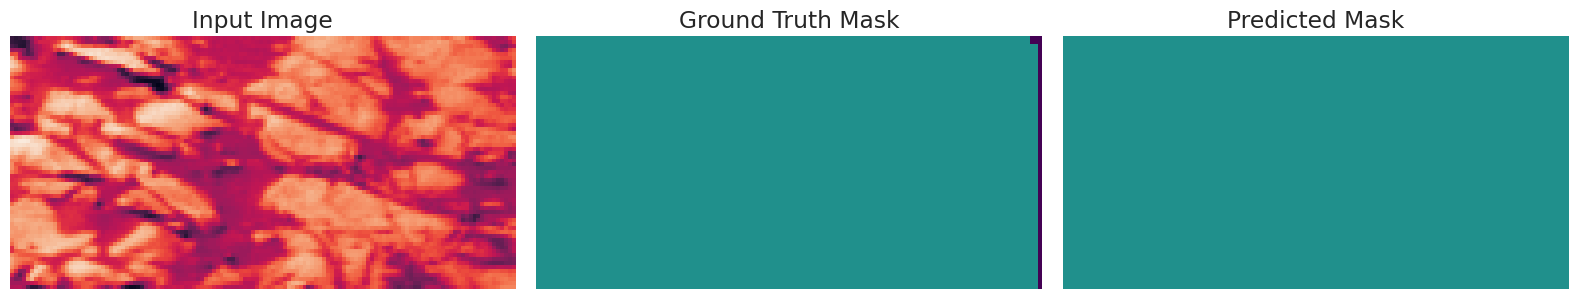

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.6750 - iou_per_class: 0.5694 - loss: 0.1836 - mean_iou: 0.7118 - val_accuracy: 0.6309 - val_iou_per_class: 0.4291 - val_loss: 0.2933 - val_mean_iou: 0.5363 - learning_rate: 1.0000e-04
Epoch 62/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6792 - iou_per_class: 0.5886 - loss: 0.1888 - mean_iou: 0.7357 - val_accuracy: 0.6382 - val_iou_per_class: 0.4377 - val_loss: 0.2832 - val_mean_iou: 0.5471 - learning_rate: 1.0000e-04
Epoch 63/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6752 - iou_per_class: 0.5687 - loss: 0.1864 - mean_iou: 0.7109 - val_accuracy: 0.6443 - val_iou_per_class: 0.4454 - val_loss: 0.2753 - val_mean_iou: 0.5567 - learning_rate: 1.0000e-04
Epoch 64/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.6760 - iou_per_class: 0.5738 - loss: 0.1854 - mean_iou: 0.7172 - val_accuracy: 0.6280 - val_iou_per_class: 0.4251 - val_loss: 0.3216 - val_mean_iou: 0.5314 - learning_rate: 1.0000e-04


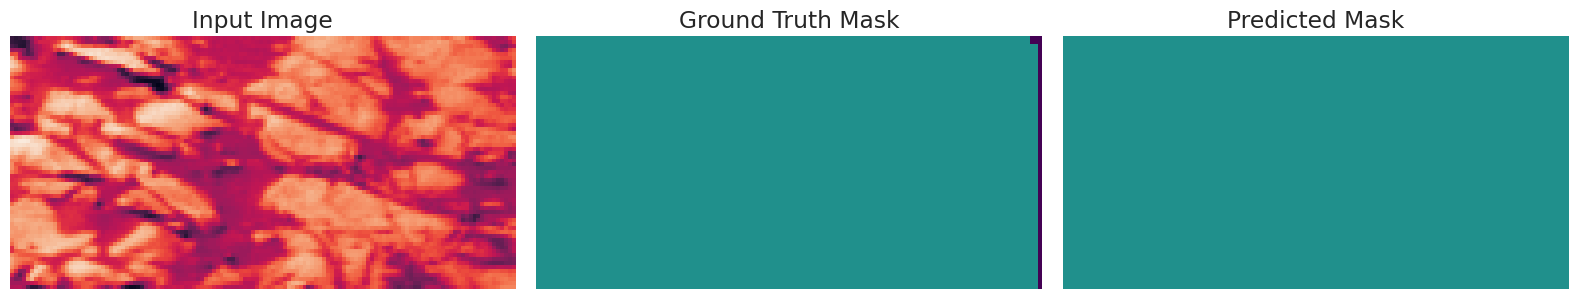

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.6768 - iou_per_class: 0.5762 - loss: 0.1813 - mean_iou: 0.7202 - val_accuracy: 0.6400 - val_iou_per_class: 0.4397 - val_loss: 0.2878 - val_mean_iou: 0.5496 - learning_rate: 1.0000e-04
Epoch 67/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.6778 - iou_per_class: 0.5850 - loss: 0.1828 - mean_iou: 0.7313 - val_accuracy: 0.6261 - val_iou_per_class: 0.4234 - val_loss: 0.3081 - val_mean_iou: 0.5292 - learning_rate: 1.0000e-04
Epoch 68/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6790 - iou_per_class: 0.5854 - loss: 0.1838 - mean_iou: 0.7317 - val_accuracy: 0.6454 - val_iou_per_class: 0.4468 - val_loss: 0.2782 - val_mean_iou: 0.5585 - learning_rate: 1.0000e-04
Epoch 69/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.6772 - iou_per_class: 0.5858 - loss: 0.1847 - mean_iou: 0.7323 - val_accuracy: 0.6351 - val_iou_per_class: 0.4337 - val_loss: 0.2885 - val_mean_iou: 0.5422 - learning_rate: 1.0000e-04


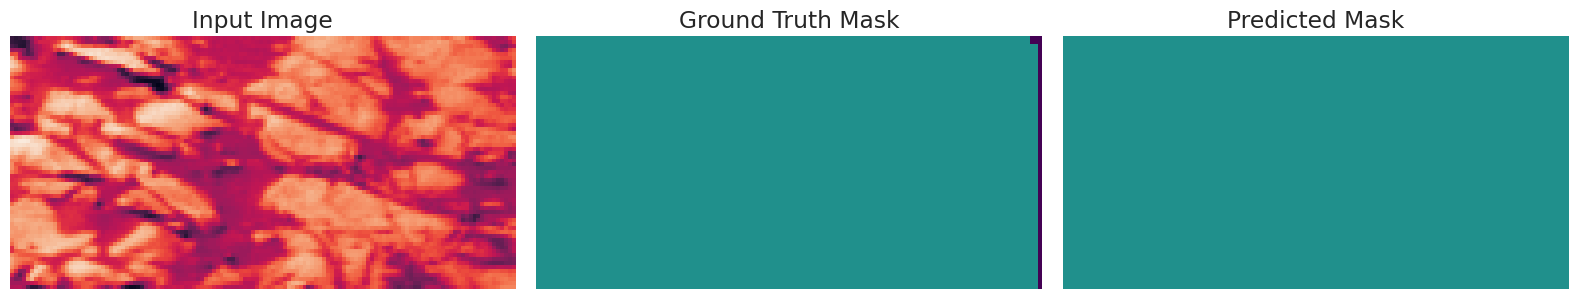

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.6775 - iou_per_class: 0.5930 - loss: 0.1809 - mean_iou: 0.7413 - val_accuracy: 0.6442 - val_iou_per_class: 0.4460 - val_loss: 0.2728 - val_mean_iou: 0.5575 - learning_rate: 1.0000e-04
Epoch 72/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.6747 - iou_per_class: 0.5832 - loss: 0.1795 - mean_iou: 0.7290 - val_accuracy: 0.6458 - val_iou_per_class: 0.4478 - val_loss: 0.2707 - val_mean_iou: 0.5597 - learning_rate: 1.0000e-04
Epoch 73/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6787 - iou_per_class: 0.5880 - loss: 0.1808 - mean_iou: 0.7349 - val_accuracy: 0.6415 - val_iou_per_class: 0.4419 - val_loss: 0.2798 - val_mean_iou: 0.5524 - learning_rate: 1.0000e-04
Epoch 74/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.6780 - iou_per_class: 0.5830 - loss: 0.1895 - mean_iou: 0.7287 - val_accuracy: 0.6605 - val_iou_per_class: 0.4652 - val_loss: 0.2558 - val_mean_iou: 0.5815 - learning_rate: 1.0000e-04


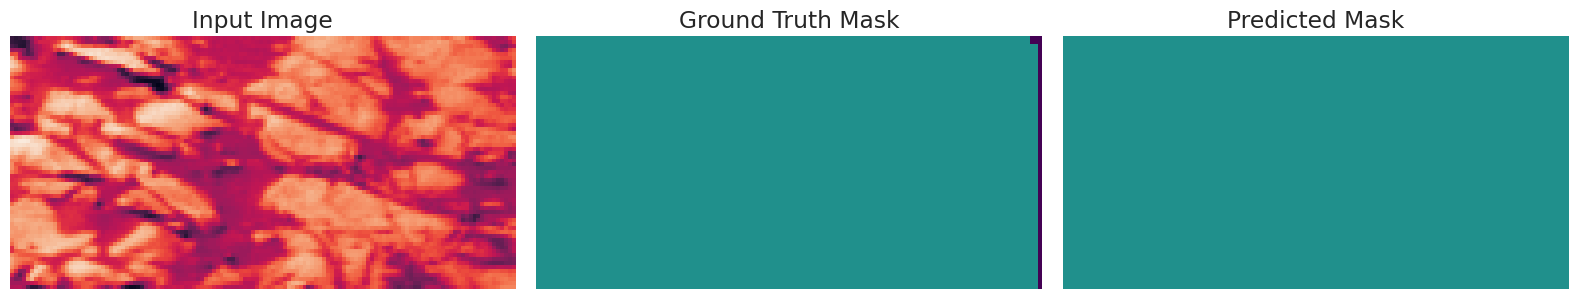

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.6788 - iou_per_class: 0.5901 - loss: 0.1738 - mean_iou: 0.7376 - val_accuracy: 0.6346 - val_iou_per_class: 0.4338 - val_loss: 0.2980 - val_mean_iou: 0.5422 - learning_rate: 1.0000e-04
Epoch 77/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6825 - iou_per_class: 0.5944 - loss: 0.1753 - mean_iou: 0.7431 - val_accuracy: 0.6305 - val_iou_per_class: 0.4284 - val_loss: 0.3089 - val_mean_iou: 0.5355 - learning_rate: 1.0000e-04
Epoch 78/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6814 - iou_per_class: 0.5825 - loss: 0.1757 - mean_iou: 0.7281 - val_accuracy: 0.6378 - val_iou_per_class: 0.4372 - val_loss: 0.2882 - val_mean_iou: 0.5465 - learning_rate: 1.0000e-04
Epoch 79/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6765 - iou_per_class: 0.5805 - loss: 0.1812 - mean_iou: 0.7256 - val_accuracy: 0.6499 - val_iou_per_class: 0.4521 - val_loss: 0.2691 - val_mean_iou: 0.5651 - learning_rate: 1.0000e-04

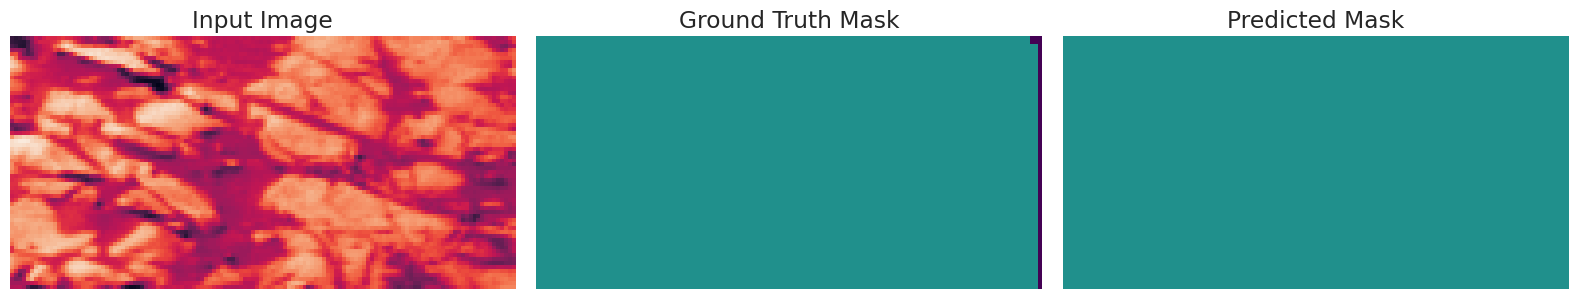

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.6817 - iou_per_class: 0.5910 - loss: 0.1723 - mean_iou: 0.7388 - val_accuracy: 0.6637 - val_iou_per_class: 0.4699 - val_loss: 0.2417 - val_mean_iou: 0.5874 - learning_rate: 1.0000e-04
Epoch 82/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.6808 - iou_per_class: 0.5954 - loss: 0.1753 - mean_iou: 0.7442 - val_accuracy: 0.6700 - val_iou_per_class: 0.4781 - val_loss: 0.2330 - val_mean_iou: 0.5976 - learning_rate: 1.0000e-04
Epoch 83/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.6827 - iou_per_class: 0.5954 - loss: 0.1677 - mean_iou: 0.7442 - val_accuracy: 0.6535 - val_iou_per_class: 0.4564 - val_loss: 0.2645 - val_mean_iou: 0.5705 - learning_rate: 1.0000e-04
Epoch 84/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.6822 - iou_per_class: 0.6032 - loss: 0.1701 - mean_iou: 0.7540 - val_accuracy: 0.6584 - val_iou_per_class: 0.4632 - val_loss: 0.2499 - val_mean_iou: 0.5790 - learning_rate: 1.0000e-04

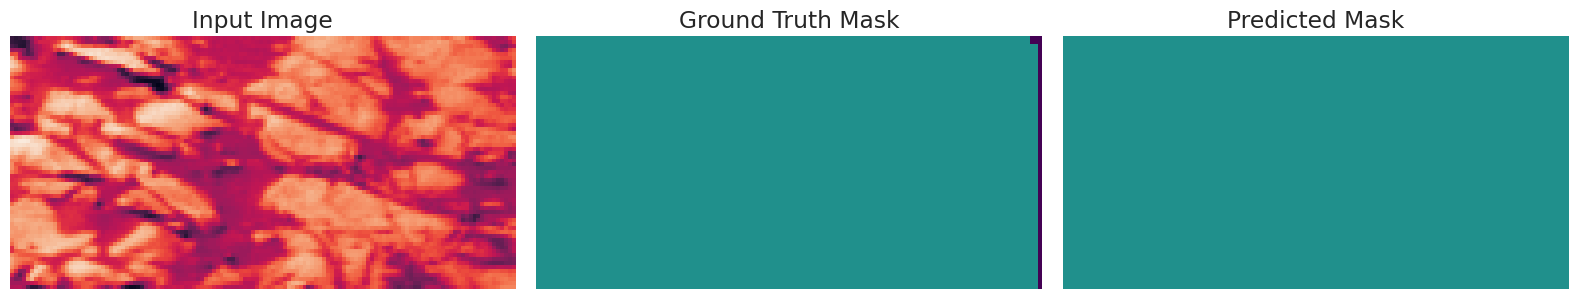

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.6803 - iou_per_class: 0.5959 - loss: 0.1732 - mean_iou: 0.7449 - val_accuracy: 0.6463 - val_iou_per_class: 0.4471 - val_loss: 0.2797 - val_mean_iou: 0.5589 - learning_rate: 1.0000e-04
Epoch 87/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.6849 - iou_per_class: 0.6011 - loss: 0.1682 - mean_iou: 0.7513 - val_accuracy: 0.6424 - val_iou_per_class: 0.4421 - val_loss: 0.2877 - val_mean_iou: 0.5526 - learning_rate: 1.0000e-04
Epoch 88/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6821 - iou_per_class: 0.5926 - loss: 0.1700 - mean_iou: 0.7408 - val_accuracy: 0.6367 - val_iou_per_class: 0.4367 - val_loss: 0.3138 - val_mean_iou: 0.5459 - learning_rate: 1.0000e-04
Epoch 89/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6825 - iou_per_class: 0.6048 - loss: 0.1664 - mean_iou: 0.7560 - val_accuracy: 0.6251 - val_iou_per_class: 0.4217 - val_loss: 0.3300 - val_mean_iou: 0.5271 - learning_rate: 1.0000e-04
Ep

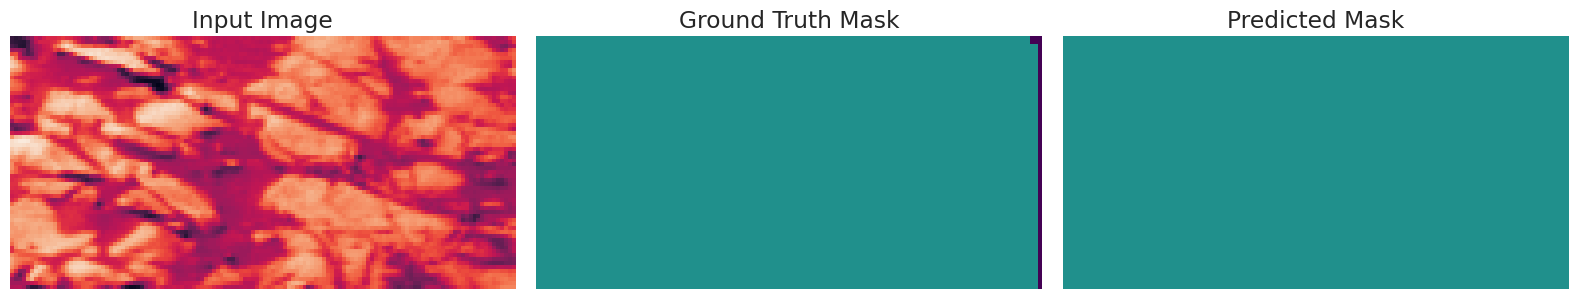

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6839 - iou_per_class: 0.6056 - loss: 0.1594 - mean_iou: 0.7570 - val_accuracy: 0.6517 - val_iou_per_class: 0.4551 - val_loss: 0.2636 - val_mean_iou: 0.5689 - learning_rate: 1.0000e-04
Epoch 92/1000
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6832 - iou_per_class: 0.6084 - loss: 0.1637 - mean_iou: 0.7605
Epoch 92: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.6815 - iou_per_class: 0.6105 - loss: 0.1646 - mean_iou: 0.7631 - val_accuracy: 0.6558 - val_iou_per_class: 0.4601 - val_loss: 0.2497 - val_mean_iou: 0.5752 - learning_rate: 1.0000e-04
Epoch 93/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6862 - iou_per_class: 0.5997 - loss: 0.1663 - mean_iou: 0.7497 - val_accuracy: 0.6513 - val_iou_per_class: 0.4552 - val_loss: 0.2488 - val_mean_iou: 0.5690 - learning_rate: 1.0000e-05
Epoch 94/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - ac

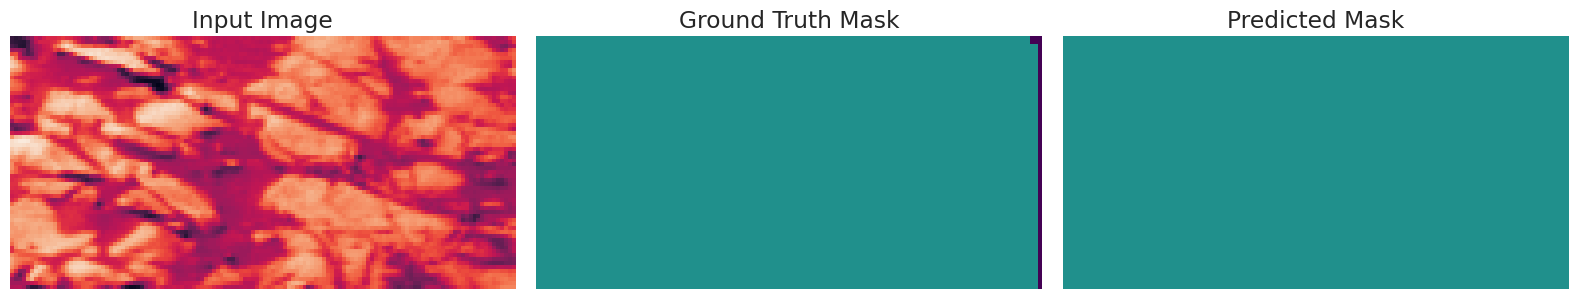

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.6838 - iou_per_class: 0.6007 - loss: 0.1601 - mean_iou: 0.7508 - val_accuracy: 0.6508 - val_iou_per_class: 0.4544 - val_loss: 0.2565 - val_mean_iou: 0.5680 - learning_rate: 1.0000e-05
Epoch 97/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6850 - iou_per_class: 0.6038 - loss: 0.1571 - mean_iou: 0.7547 - val_accuracy: 0.6496 - val_iou_per_class: 0.4531 - val_loss: 0.2578 - val_mean_iou: 0.5664 - learning_rate: 1.0000e-05
Epoch 98/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6874 - iou_per_class: 0.6156 - loss: 0.1537 - mean_iou: 0.7695 - val_accuracy: 0.6500 - val_iou_per_class: 0.4533 - val_loss: 0.2587 - val_mean_iou: 0.5667 - learning_rate: 1.0000e-05
Epoch 99/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.6868 - iou_per_class: 0.6033 - loss: 0.1602 - mean_iou: 0.7541 - val_accuracy: 0.6512 - val_iou_per_class: 0.4551 - val_loss: 0.2569 - val_mean_iou: 0.5688 - learning_rate: 1.0000e-05


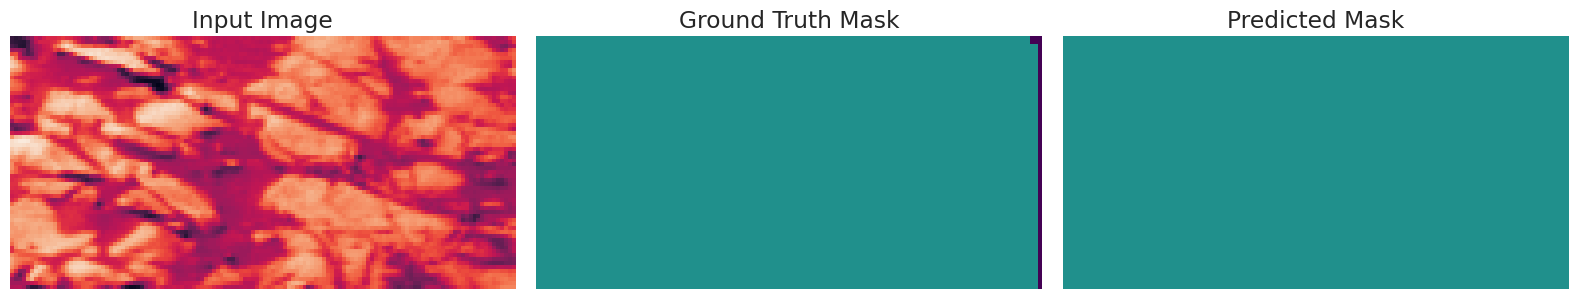

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6876 - iou_per_class: 0.6067 - loss: 0.1557 - mean_iou: 0.7584 - val_accuracy: 0.6444 - val_iou_per_class: 0.4464 - val_loss: 0.2705 - val_mean_iou: 0.5580 - learning_rate: 1.0000e-05
Epoch 102/1000
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6855 - iou_per_class: 0.6054 - loss: 0.1553 - mean_iou: 0.7567
Epoch 102: ReduceLROnPlateau reducing learning rate to 1e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6838 - iou_per_class: 0.6078 - loss: 0.1564 - mean_iou: 0.7597 - val_accuracy: 0.6476 - val_iou_per_class: 0.4501 - val_loss: 0.2653 - val_mean_iou: 0.5626 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 59.76%


In [ ]:
# Train the model



history = model.fit(



    train_dataset,



    epochs=EPOCHS,



    validation_data=val_dataset,



    callbacks=[early_stopping, viz_callback,reduce_lr, IoUCallback(frequency=5)],#reduce_lr



    verbose=1



).history







# Calculate and print the final validation accuracy



final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)



print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')







# Save the trained model to a file with the accuracy included in the filename



model_filename = 'Unet_'+str(final_val_meanIoU)+'.keras'



model.save(model_filename)







# Delete the model to free up resources



del model

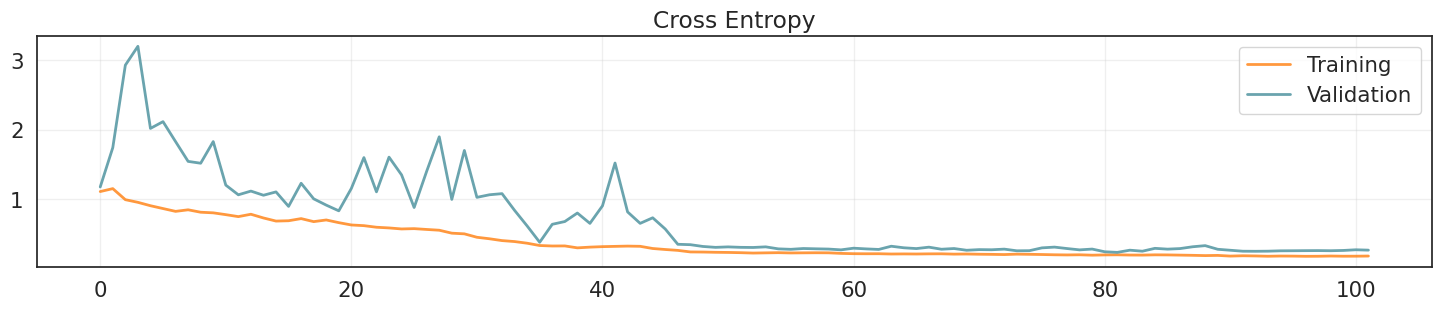

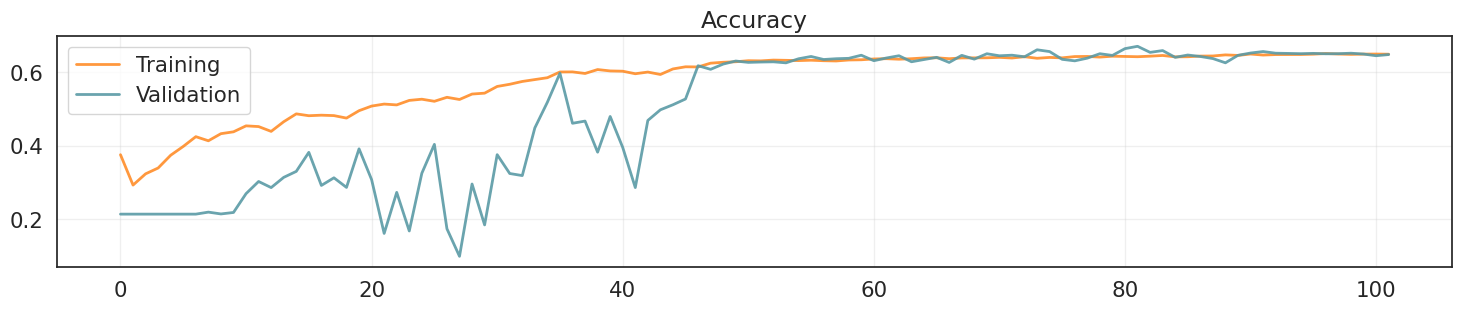

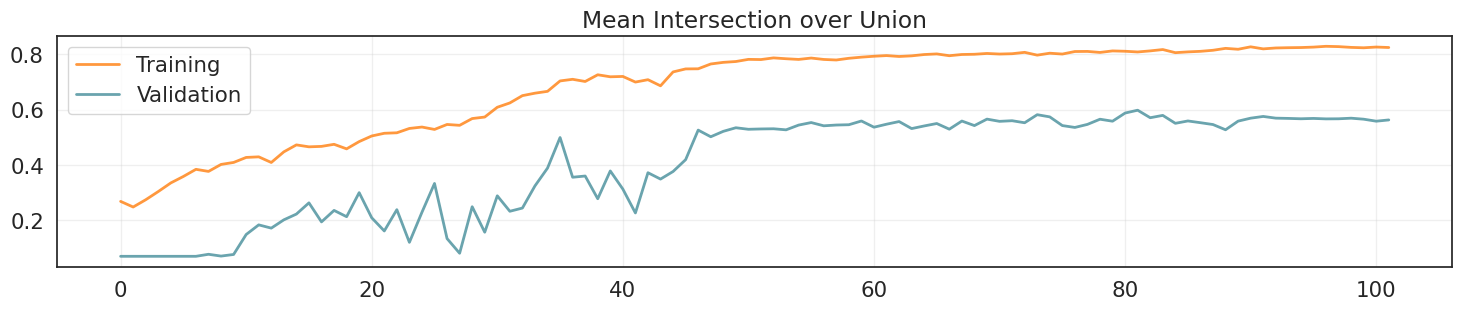

In [ ]:
# Plot and display training and validation loss



plt.figure(figsize=(18, 3))



plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)



plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)



plt.title('Cross Entropy')



plt.legend()



plt.grid(alpha=0.3)



plt.show()







# Plot and display training and validation accuracy



plt.figure(figsize=(18, 3))



plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)



plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)



plt.title('Accuracy')



plt.legend()



plt.grid(alpha=0.3)



plt.show()







# Plot and display training and validation mean IoU



plt.figure(figsize=(18, 3))



plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)



plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)



plt.title('Mean Intersection over Union')



plt.legend()



plt.grid(alpha=0.3)



plt.show()

## 🕹️ Use the Model - Make Inference

In [ ]:
# Load UNet model without compiling



model = tfk.models.load_model(model_filename, compile=False)







# Compile the model with specified loss, optimizer, and metrics



model.compile(



    loss=tf.keras.losses.SparseCategoricalCrossentropy(),



    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),



    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]



)







# Print a detailed summary of the model with expanded nested layers and trainable parameters.



model.summary(expand_nested=True, show_trainable=True)







# Generate and display a graphical representation of the model architecture.



#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ keras_tensor_58CLONE   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ keras_tensor_58CLO… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_shortcut   │ (None, 64, 128, 32)  │           64 │ keras_tensor_58CLO… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_add (Add)  │ (None, 64, 128, 32)  │            0 │ down_block1_activa… │    -    │
│                        │                      │              │ down_block1_shortc… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_residual_… │ (None, 64, 128, 32)  │            0 │ down_block1_add[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 32)   │            0 │ down_block1_residu… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_2[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 501,805 (1.91 MB)

 Trainable params: 500,525 (1.91 MB)

 Non-trainable params: 1,280 (5.00 KB)

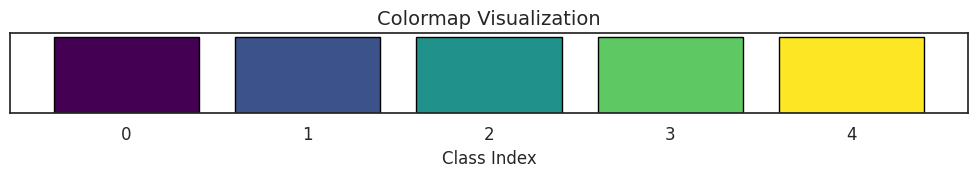

In [ ]:
def visualize_colormap(colormap, num_classes):

    """

    Visualize the given colormap by plotting color swatches with class indices.



    Parameters:

    colormap: numpy.ndarray - The colormap array with shape (num_classes, 3 or 4).

    num_classes: int - The number of classes.

    """

    plt.figure(figsize=(10, 2))



    # Create a horizontal bar for each class

    for i in range(num_classes):

        plt.bar(i, 1, color=colormap[i], edgecolor="black")



    # Add labels for each class

    plt.xticks(range(num_classes), labels=range(num_classes), fontsize=12)

    plt.yticks([])  # Hide y-axis

    plt.title("Colormap Visualization", fontsize=14)

    plt.xlabel("Class Index", fontsize=12)

    plt.tight_layout()

    plt.show()



visualize_colormap(COLORMAP, NUM_CLASSES)

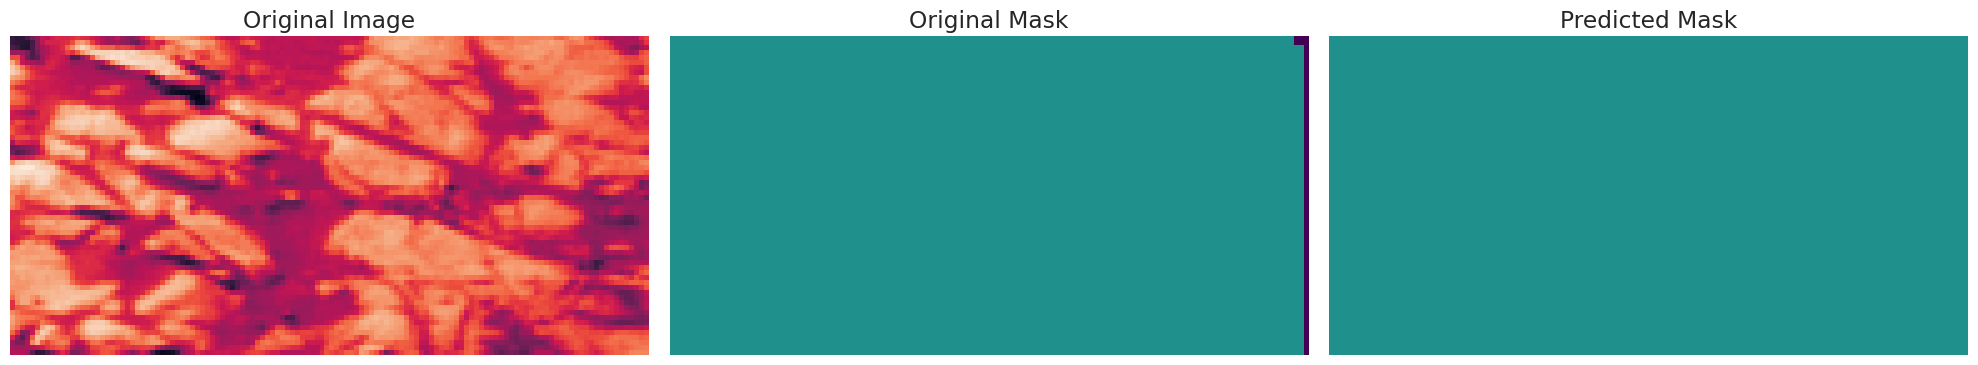

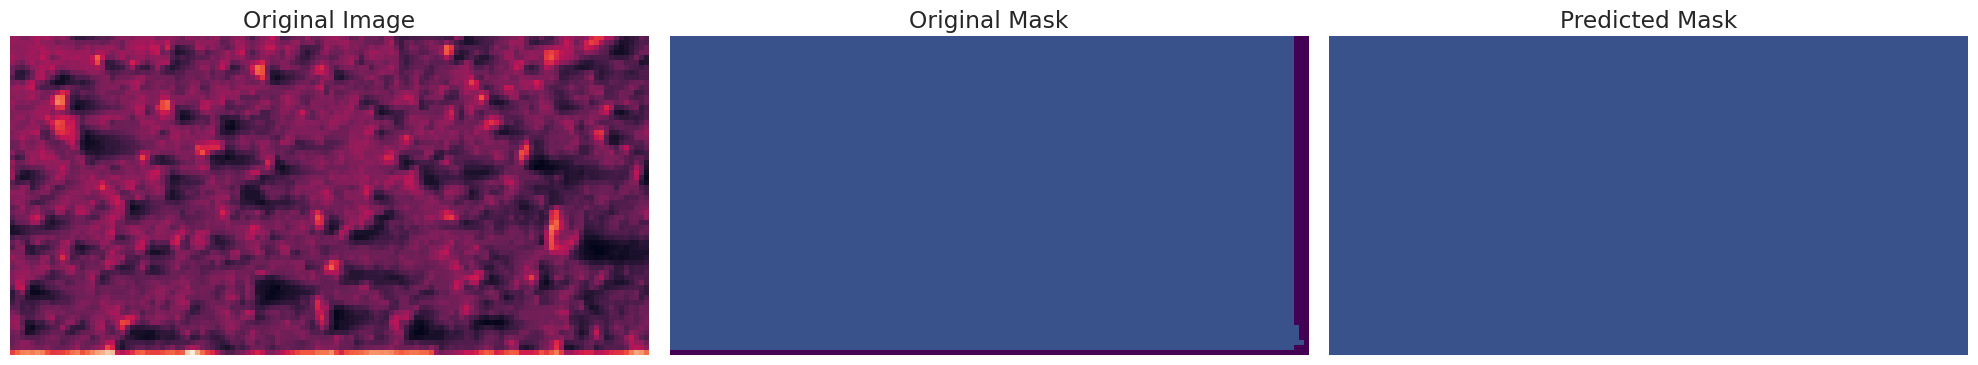

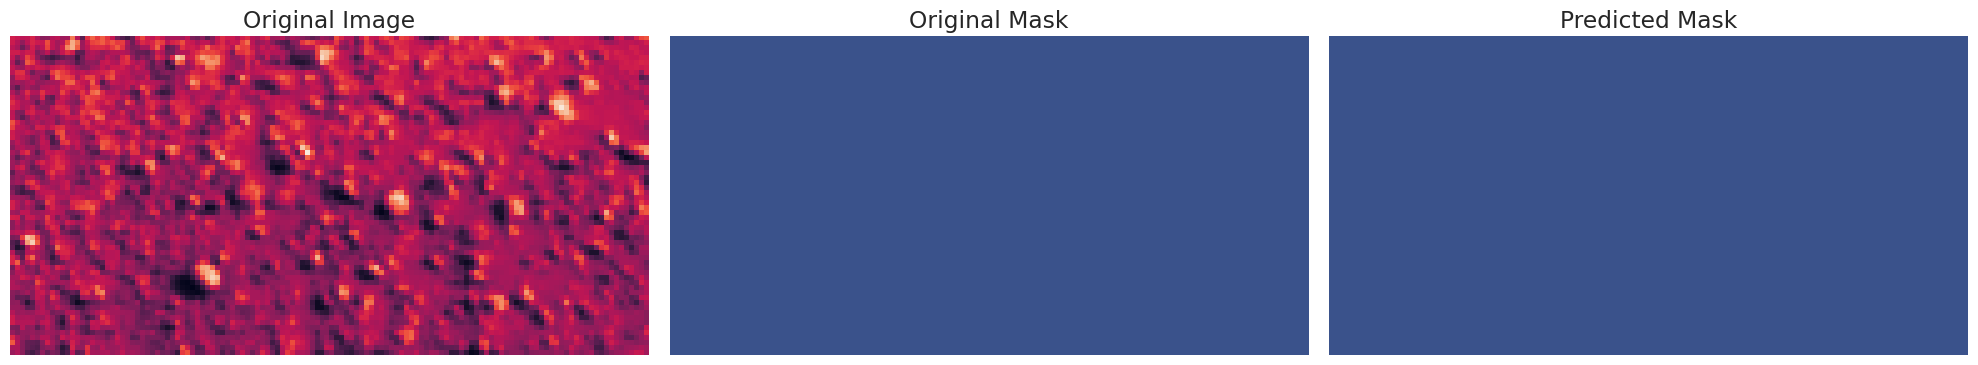

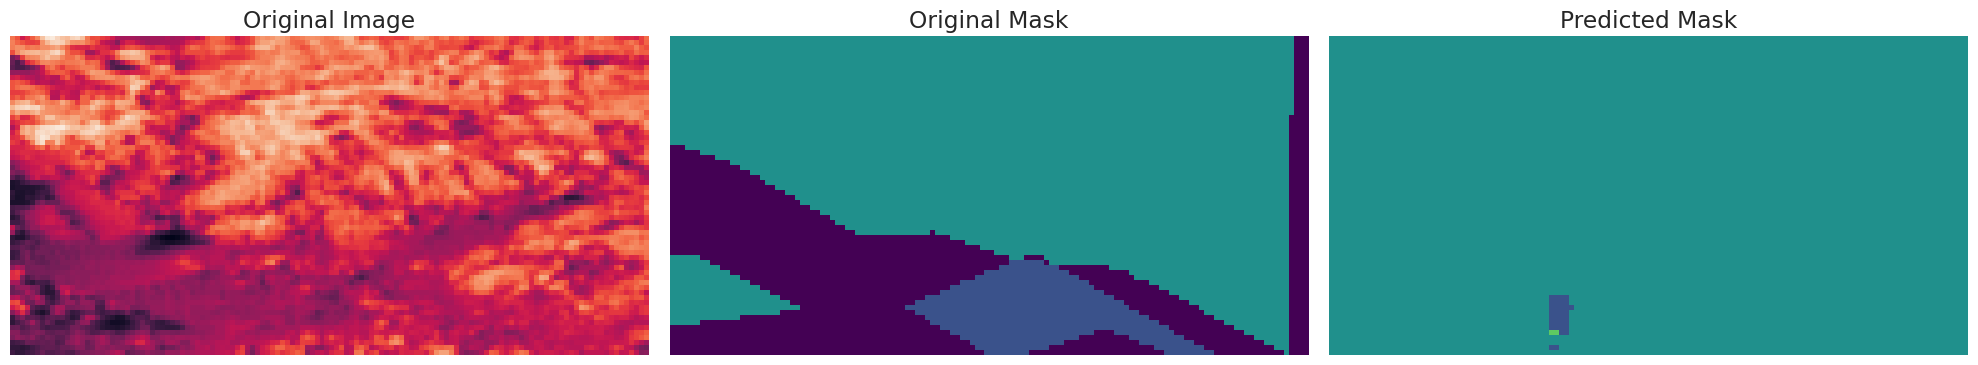

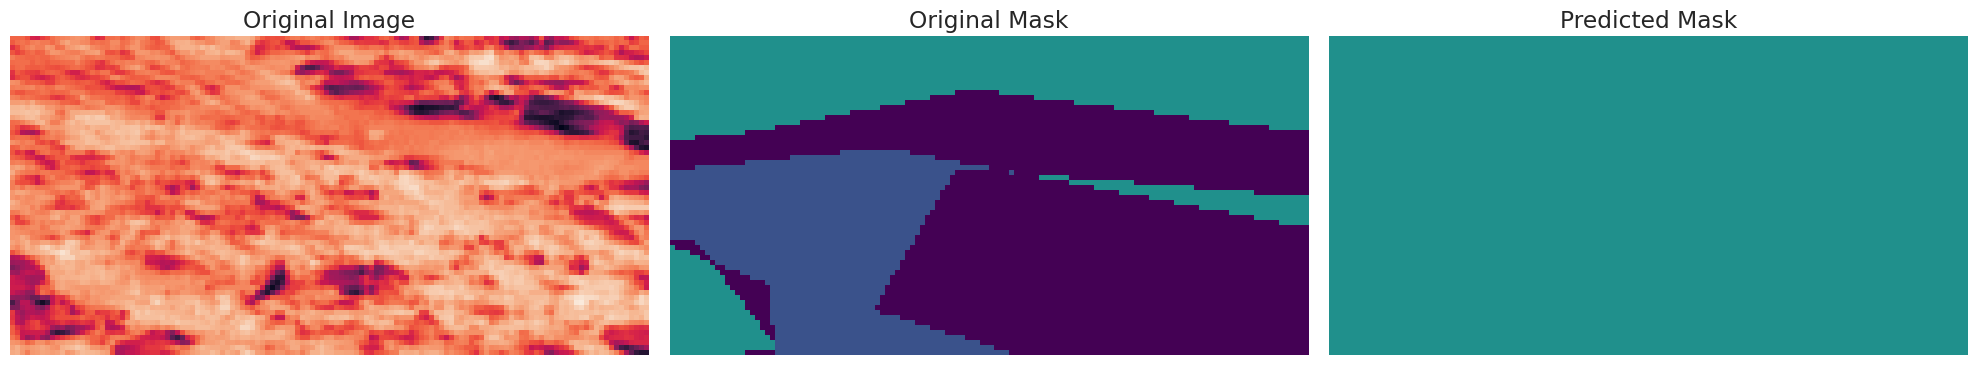

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):



    """



    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset







    Parameters:



    dataset: tf.data.Dataset - The dataset containing image-label pairs



    model: tf.keras.Model - The trained model to generate predictions



    num_samples: int - Number of samples to plot



    """



    # Take samples from the dataset



    # Unbatch the dataset to get individual samples

    unbatched_dataset = dataset.unbatch().take(num_samples)







    for images, labels in unbatched_dataset.as_numpy_iterator():





      # Ensure images and labels are expanded to simulate a batch

        images = np.expand_dims(images, axis=0)

        labels = np.expand_dims(labels, axis=0)





        # Generate predictions



        pred = model.predict(images, verbose=0)



        pred = tf.math.argmax(pred, axis=-1)







        # Create colormap based on number of classes in labels



        num_classes = len(np.unique(labels))



        colormap = create_segmentation_colormap(num_classes)







        # Create figure with subplots



        fig, axes = plt.subplots(1, 3, figsize=(20, 4))







        # Plot original image



        axes[0].set_title("Original Image")



        axes[0].imshow(images[0])



        axes[0].axis('off')







        # Plot original mask



        axes[1].set_title("Original Mask")



        colored_label = apply_colormap(np.squeeze(labels[0], axis=-1), colormap)



        axes[1].imshow(colored_label)



        axes[1].axis('off')







        # Plot predicted mask



        axes[2].set_title("Predicted Mask")



        colored_pred = apply_colormap(pred[0], colormap)



        axes[2].imshow(colored_pred)



        axes[2].axis('off')







        plt.tight_layout()



        plt.show()



        plt.close()







# Example usage:



# Plot three random samples



plot_triptychs(val_dataset, model, num_samples=5)

In [ ]:
#timestep_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")

#model_filename = f"model_{timestep_str}.keras"

model.save(model_filename)

del model



print(f"Model saved to {model_filename}")

Model saved to Unet_59.76.keras


## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive

if "model_filename" not in globals() or model_filename is None:

    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]

    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    if files:

        model_filename = files[0]

    else:

        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename, compile=False)

print(f"Model loaded from {model_filename}")

Model loaded from Unet_59.76.keras


In [ ]:
preds = model.predict(X_test)

preds = np.argmax(preds, axis=-1)

print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]

In [ ]:
# Create and download the csv submission file

timestep_str = model_filename.replace("model_", "").replace(".keras", "")

os.makedirs("submissions", exist_ok=True)

submission_filename = f"submissions/submission_{timestep_str}.csv"

submission_df = y_to_df(preds)

submission_df.to_csv(submission_filename, index=False)



if IN_COLAB:

    from google.colab import files

    files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>